In [29]:
import os
import pandas as pd
import numpy as np
import math
import empyrical as empy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


from sklearn.metrics import accuracy_score, precision_score, explained_variance_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [30]:
csv = './data/XAU_USD.csv'
start = '1985'
end = '2021'


In [31]:
def print_clustermap(data, title='', figsize=(12,12)):
    
    corr = data.corr()
    '''data_clean = data.applymap(lambda x: x if x!=0 else np.nan)
    for n in ['Growth','Mod','FICon','Con']:
        data_clean[n] = data_clean[n].fillna(0)
    corr = data_clean.corr()
    '''
    g = sns.clustermap(corr, method="complete", cmap='PuOr', annot=True, 
                   annot_kws={"size": 10}, vmin=-1, vmax=1, figsize=figsize)
    g.fig.suptitle(title)
    plt.show()

In [32]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        #print('i', i)
        #print('j', j)
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()


In [33]:
def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [total_return, empy.annual_return, empy.sharpe_ratio, empy.annual_volatility, 
                empy.max_drawdown, avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    return se


In [34]:
def predict_freq(pred, freq='M'):
    
    #print(pred)
    #print(pred[pred.index.duplicated()])
    
    idx = pred.index.to_series()
    idx_m = idx.groupby(pd.Grouper(freq=freq)).first()
    pred_m = pred.groupby(pd.Grouper(freq=freq)).first()
    pred_m.index = idx_m
    
    #print(idx)
    #print(idx[idx.index.duplicated()])
    #print(pred_m)
    #print(pred_m[pred_m.index.duplicated()])
    
    pred_m = pred_m.dropna().reindex(idx).ffill()
    
    return pred_m


In [35]:
sma = lambda x, y: x.rolling(int(y)).mean()

ewma = lambda x, y: x.ewm(span=y).mean()

def s(x,x0,x1,y0=0,y1=1,d=np.nan):
    if x>=x1:
        return y1
    if x<x0:
        return y0
    return d


In [36]:
def exp_sum(se):
    _sum = 0
    for i,v in enumerate(se):
        _sum += v*(2**i)
    return _sum
def cont_n_01(x, n):
    if x <= 0:
        return 0
    if x >= 2**n - 1:
        return 1
    return np.nan
def predict_cont_n(vote, n, rb_lookback=True):
    if not rb_lookback:
        v_tmp = vote.groupby(pd.Grouper(freq='M')).apply(lambda x: predict_cont_n(x, n)).values
        return pd.Series(v_tmp, index=vote.index)
    vres = vote.rolling(n).apply(lambda x: exp_sum(x))
    vote_c = vres.apply(lambda x: cont_n_01(x, n))
    if np.isnan(vote_c.iloc[0]):
        vote_c.iloc[0] = vote.iloc[0]
    vote_c = vote_c.ffill()
    return vote_c

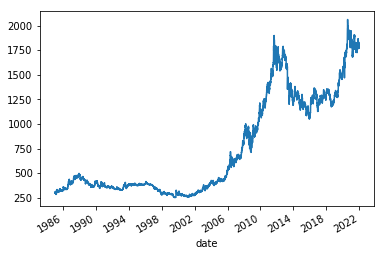

In [37]:
price = pd.read_csv(csv, index_col=0)['adj_close']
price.index = pd.to_datetime(price.index)
price[start:end].plot()

In [38]:
true_ret = price.pct_change()
true_ret = true_ret[start:end]
true_ret

date
1985-01-02   -0.009082
1985-01-03   -0.010475
1985-01-04    0.002646
1985-01-07   -0.016166
1985-01-08    0.012743
                ...   
2021-12-27    0.001543
2021-12-28   -0.003054
2021-12-29   -0.000947
2021-12-30    0.006293
2021-12-31    0.007372
Name: adj_close, Length: 9612, dtype: float64

In [39]:
true_up = (true_ret>=0)
true_up

date
1985-01-02    False
1985-01-03    False
1985-01-04     True
1985-01-07    False
1985-01-08     True
              ...  
2021-12-27     True
2021-12-28    False
2021-12-29    False
2021-12-30     True
2021-12-31     True
Name: adj_close, Length: 9612, dtype: bool

In [40]:
def other_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(other_metric).T
    
    pred_up = (ret!=0)*1
    
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    
    idx_tmp = pred_up.index & true_up.index
    true_up_tmp = true_up.reindex(idx_tmp) * 1
    pred_up = pred_up.reindex(idx_tmp) * 1
    accu = accuracy_score(true_up_tmp, pred_up)
    prec = precision_score(true_up_tmp, pred_up)
    
    true_up_pct = true_ret.reindex(idx_tmp)
    true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
    
    mse = mean_squared_error(true_up_pct_scaled, pred_up)
    
    se = pd.Series(dtype='float64')
    
    se['highlight_ratio'] = highlight_ratio
    se['flip_ratio'] = flip_ratio
    se['accu'] = accu
    se['prec'] = prec
    se['mse'] = mse
    
    return se


In [41]:
def ret_short_once_every_interval(ret, shorting_interval):
    
    ret_short = ret.copy()
    
    t_prev = ret.index[0]
    cum_prod_prev = 1
    t_start_short = ret.index[0]
    cum_prod = 1
    
    for t in ret.index[1:]:
        if shorting_interval[t]:
            if not shorting_interval[t_prev]:
                t_start_short = t
                
            cum_prod = 2 - (1+ret[t_start_short:t]).prod()
            if cum_prod <= 0:
                ret_short[t:] = 0
                ret_short[t] = -1
                
                print('t_start_short', t_start_short)
                print('price', price[t_start_short])
                print('t', t)
                print('price', price[t])
                
                print('broke on', t)
                
                break
            ret_short[t] = cum_prod / cum_prod_prev - 1
                
                
        else:
            cum_prod = 1
        
        t_prev = t
        cum_prod_prev = cum_prod
    
    return ret_short
    

In [42]:
true_ret

date
1985-01-02   -0.009082
1985-01-03   -0.010475
1985-01-04    0.002646
1985-01-07   -0.016166
1985-01-08    0.012743
                ...   
2021-12-27    0.001543
2021-12-28   -0.003054
2021-12-29   -0.000947
2021-12-30    0.006293
2021-12-31    0.007372
Name: adj_close, Length: 9612, dtype: float64

In [43]:
def sim_indicator(pred_up, name, plot=False):
    
    pred_up = pred_up.reindex(true_ret.index).ffill()
    
    indicator = pred_up[pred_up==1].index
    
    
    ret_df = pd.DataFrame()

    #ret_df['buy_and_hold'] = ret[start:]

    ret_i = true_ret.copy()
    ret_i.loc[~ret_i.index.isin(indicator)] = 0
    ret_df['hold_only_pred_up_{}'.format(name)] = ret_i
    
    #highlight_ratio = ret_i.apply(lambda x: 1 if x!=0 else 0).mean()
    
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    
    
    
    #print('highlight_ratio', highlight_ratio)
    #print('flip_ratio', flip_ratio)
    
    
    empy_met = empy_metric(ret_df)
    
    
    other_met = other_metric(ret_df)
    
    """
    for k in [5,10,21]:
        pct_change = (price.shift(1-k) - price.shift(1))/price.shift(1)
        pct_change = pct_change.reindex(idx_tmp)
        true_up_k = (pct_change>=0)*1
        other_met['accu{}'.format(k)] = [accuracy_score(true_up_k, pred_up)]
        other_met['prec{}'.format(k)] = [precision_score(true_up_k, pred_up)]
        
        #true_up_pct_scaled = (pct_change-pct_change.min())/(pct_change.max()-pct_change.min())
        true_up_pct_scaled = pct_change/pct_change.std() + 0.5
        #other_met['expvar{}'.format(k)] = [explained_variance_score(true_up_pct_scaled, pred_up)]
        other_met['mse{}'.format(k)] = [mean_squared_error(true_up_pct_scaled, pred_up)]
        
    """
    
    if plot:
        fig, ax = plt.subplots()
        (1+ret_df).cumprod().plot(ax=ax)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_yscale("log")
        plt.show()
    
    res = {}
    res['ret_df'] = ret_df
    res['empy_metric'] = empy_met
    res['other_metric'] = other_met
    
    return res
    

In [44]:
def sim_indicator_prob(prob_up, name, plot=False):
    
    #indicator = pred_up[pred_up==1].index
    
    
    ret_df = pd.DataFrame()

    #ret_df['buy_and_hold'] = ret[start:]

    ret_i = ret[start:end].copy()
    #ret_i.loc[~ret_i.index.isin(indicator)] = 0
    ret_df['hold_only_pred_up_{}'.format(name)] = ret_i*prob_up[start:end]
    
    #highlight_ratio = ret_i.apply(lambda x: 1 if x!=0 else 0).mean()
    
    highlight_ratio = prob_up.mean()
    #flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    flip_ratio = (prob_up - prob_up.shift()).abs().mean()
    
    
    
    #print('highlight_ratio', highlight_ratio)
    #print('flip_ratio', flip_ratio)
    
    
    empy_met = empy_metric(ret_df)
    
    pred_up = prob_up.apply(lambda x: 0 if x<0.5 else 1)
    
    
    true_up = (ret[start:]>=0).dropna()
    idx_tmp = pred_up.index & true_up.index
    true_up = true_up.reindex(idx_tmp) * 1
    pred_up = pred_up.reindex(idx_tmp) * 1
    prob_up = prob_up.reindex(idx_tmp) * 1
    accu = accuracy_score(true_up, pred_up)
    prec = precision_score(true_up, pred_up)
    '''
    true_up21 = (price.shift(-20) - price.shift(1))>=0
    true_up21 = true_up21.reindex(idx_tmp) * 1
    accu21 = accuracy_score(true_up21, pred_up)
    '''
    
    true_up_pct = ret.reindex(idx_tmp)
    #true_up_pct_scaled = (true_up_pct-true_up_pct.min())/(true_up_pct.max()-true_up_pct.min())
    true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
    
    expvar = explained_variance_score(true_up_pct_scaled, prob_up)
    mse = mean_squared_error(true_up_pct_scaled, prob_up)
    
    
    other_met = pd.DataFrame()
    other_met['highlight_ratio'] = [highlight_ratio]
    other_met['flip_ratio'] = [flip_ratio]
    other_met['accu'] = [accu]
    other_met['prec'] = [prec]
    other_met['expvar'] = [expvar]
    other_met['mse'] = [mse]
    
    
    #other_met['accu21'] = [accu21]
    
    for k in [5,10,21]:
        pct_change = (price.shift(1-k) - price.shift(1))/price.shift(1)
        pct_change = pct_change.reindex(idx_tmp)
        true_up_k = (pct_change>=0)*1
        other_met['accu{}'.format(k)] = [accuracy_score(true_up_k, pred_up)]
        other_met['prec{}'.format(k)] = [precision_score(true_up_k, pred_up)]
        
        #true_up_pct_scaled = (pct_change-pct_change.min())/(pct_change.max()-pct_change.min())
        true_up_pct_scaled = pct_change/pct_change.std() + 0.5
        other_met['expvar{}'.format(k)] = [explained_variance_score(true_up_pct_scaled, prob_up)]
        other_met['mse{}'.format(k)] = [mean_squared_error(true_up_pct_scaled, prob_up)]
        
    
    
    
    
    
    #other_met['accu'] = [accu]
    #other_met['accu21'] = [accu21]
    
    #display(empy_met)
    
    if plot:
        fig, ax = plt.subplots()
        (1+ret_df).cumprod().plot(ax=ax)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_yscale("log")
        plt.show()
    
    res = {}
    res['ret_df'] = ret_df
    res['empy_metric'] = empy_met
    res['other_metric'] = other_met
    
    return res
    

In [45]:
def print_all_result(ret_df, proba_df=None, topn=10, strategy_list_sel=None, base_case=None):
    
    display('{} to {}'.format(ret_df.index[0], ret_df.index[-1]))
    
    column_selected = ['annual_return', 'sharpe_ratio', 'max_drawdown', 'avg_drawdown', 'return/avgdd',]
    empy_metric_tmp = empy_metric(ret_df).sort_values('sharpe_ratio')
    if strategy_list_sel is None:

        strategy_list_sel = list(empy_metric_tmp.index)

        strategy_list_sel = strategy_list_sel[-topn:]

    if 'buy_and_hold' in strategy_list_sel:
        strategy_list_sel = [x for x in strategy_list_sel if x !='buy_and_hold']
    
    base_list = ['buy_and_hold']
    if base_case is not None:
        for bc in base_case:
            if bc == 'buy_and_hold':
                continue
            else:
                if bc not in strategy_list_sel:
                    base_list.append(bc)
    strategy_list_sel = base_list+strategy_list_sel
    
    other_metric_tmp = other_metric(ret_df)
    
    display(other_metric_tmp.loc[strategy_list_sel[1:]].iloc[:,:5])
    display(empy_metric_tmp.loc[strategy_list_sel][column_selected])
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret_df[strategy_list_sel].shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


    (1+ret_df[strategy_list_sel]).cumprod().plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()
    
#     cvals  = [0, 0.5, 1]
#     colors = ["red", 'white', "lawngreen"]
#     cmap = LinearSegmentedColormap.from_list("", colors)
#     norm=plt.Normalize(min(cvals),max(cvals))
#     tuples = list(zip(map(norm,cvals), colors))
#     cmap = LinearSegmentedColormap.from_list("", tuples)
#     sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm
#     sm.set_array([])

    
    if proba_df is None:
        return strategy_list_sel

    alpha = 1
    dot_size = 20
    
    for case in strategy_list_sel:
        if case not in proba_df.columns:
            continue
        print("====================================", case)
        try:
            fig, ax = plt.subplots(figsize=(12,6))
            proba_df.loc[ret_df.index, case].plot(kind='bar', ax=ax)
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_title(case + ' proba')
            plt.show()
            
            
            
            df_temp = pd.concat([ret_df[case], proba_df[case]],1,keys=['return','pred prob']).dropna()

    #         df_temp['log return'] = (1+df_temp['return']).apply(math.log)
    #         df_temp['cumulative return'] = (1+df_temp['return']).cumprod()-1
            df_temp['log cumulative return'] = (1+df_temp['return']).cumprod().apply(math.log)

            z_ret = ret_df[case]/ret_df[case].std()
            z_prod = (proba_df[case]-0.5)/proba_df[case].std()
            df_temp['score'] = 3-abs(z_ret-z_prod)

            df_temp = df_temp.reset_index()
            df_temp['date'] = pd.to_datetime(df_temp['index'])
            
#             display(df_temp)
            
            plot_hue = 'pred prob'
        
            cvals  = [0,0.5,1]
            colors = ["red","white","lawngreen"]
            norm = plt.Normalize(min(cvals),max(cvals))
            tuples = list(zip(map(norm,cvals), colors))
            cmap_prob = LinearSegmentedColormap.from_list("", tuples)
            sm_prob = plt.cm.ScalarMappable(cmap=cmap_prob, norm=norm)
            sm_prob.set_array([])
            
            fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,20))
            ax[0] = sns.scatterplot(data=df_temp, x='date', y='log cumulative return', hue=plot_hue,
                                 #hue='score', alpha=0.5, palette=cmap, s=20)
                                 alpha=0.5, palette=cmap_prob, s=dot_size
#                                  cmap=cmap_prob
                                )

            ax[0].set_xlim([df_temp['date'].iloc[0], df_temp['date'].iloc[-1]])
            ax[0].get_legend()#.remove()
#             ax.set_yscale("log")
            ax[0].figure.colorbar(sm_prob)
            ax[0].set_title("{} {}".format(case, plot_hue))
        
#             proba_df.loc[ret_df.index, case].plot(kind='bar', ax=ax[1])
            ax[1].plot(proba_df['date'], proba_df[case])
            ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax[1].set_title(case + ' proba')
            plt.show()

        except:
            continue
    
    
    return strategy_list_sel
    

In [46]:
## moving average ribbon

In [47]:
la = [20,50,100,200]
lb = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
lc = [34+n*13 for n in range(1, 5)]
ll = list(set(la+lb+lc))
ll.sort()
ll

[20, 25, 30, 35, 40, 45, 47, 50, 55, 60, 65, 73, 86, 100, 200]

In [48]:
ema_all = {'ema{}'.format(span): ewma(price.shift(), span) for span in ll}
ema_all = pd.DataFrame(ema_all)[start:end]
ema_all.shape

(9612, 15)

In [66]:
df = pd.concat([ema_all, price.shift()],axis=1)
df.index = pd.to_datetime(df.index)

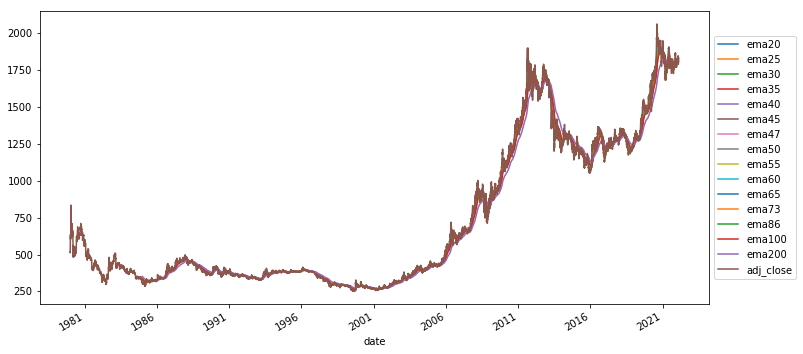

In [49]:
fig, ax = plt.subplots(figsize=(12,6))
df.plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

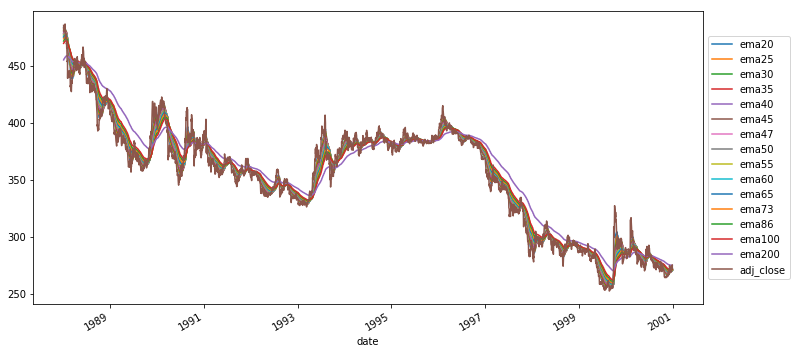

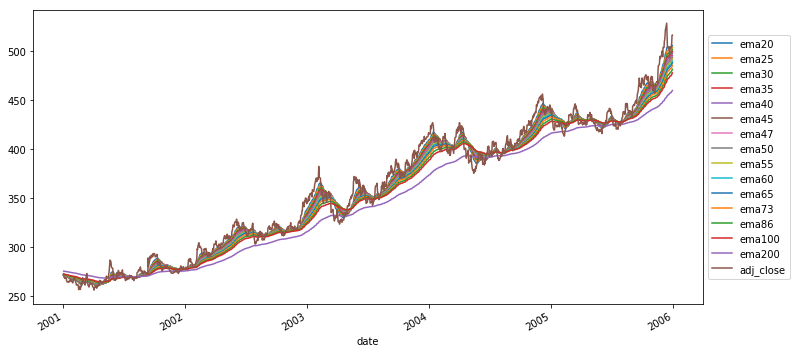

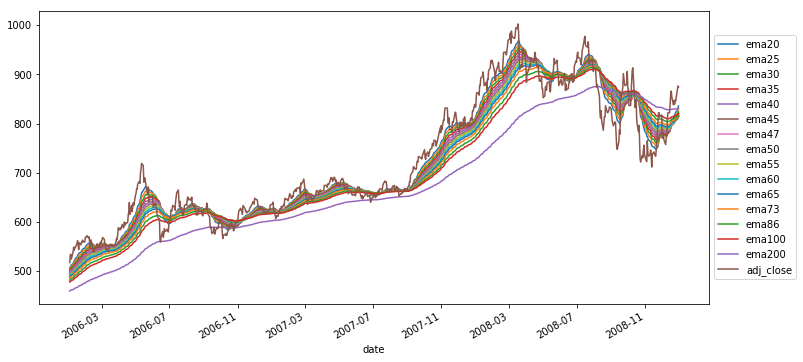

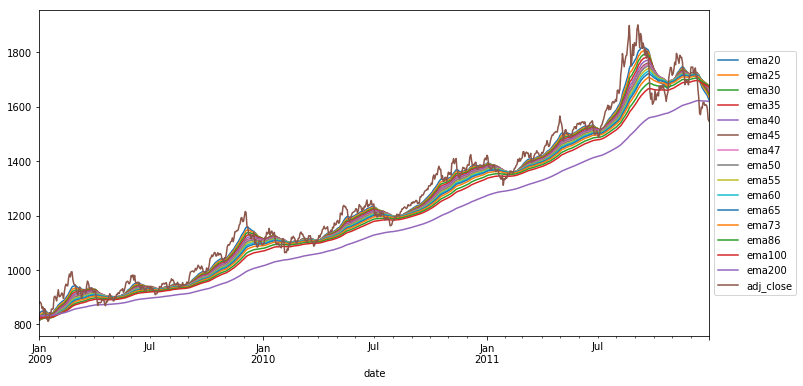

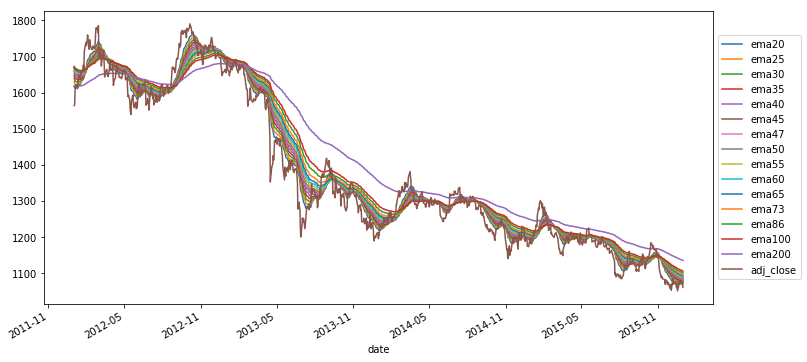

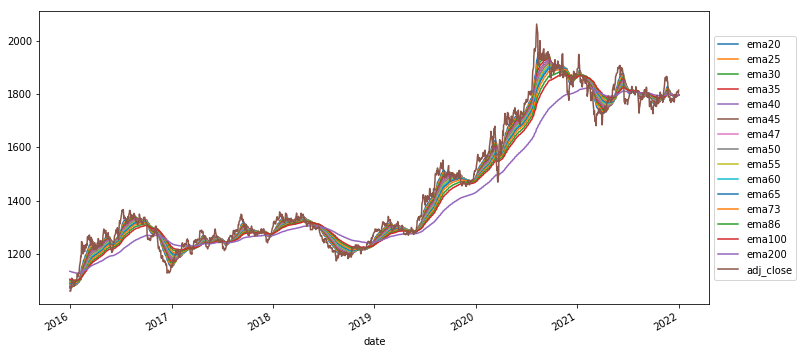

In [67]:
pps =  [('1988','2000'), ('2001','2005'), ('2006', '2008'), ('2009', '2011'), ('2012', '2015'), ('2016', '2021')]

for pp in pps:
    fig, ax = plt.subplots(figsize=(12,6))
    df[pp[0]:pp[1]].plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [50]:
pred_ema = pd.DataFrame(1, index=true_ret.index, columns=['buy_and_hold'])
for fast in ll:
    name_fast = 'ema{}'.format(fast)
    for slow1 in ll:
        name_slow1 = 'ema{}'.format(slow1)
        if slow1 > fast:
            name_pred = 'cross_ema_{}_{}'.format(fast, slow1)
            pred_tmp = ((ema_all[name_fast] > ema_all[name_slow1])*1)
            pred_ema[name_pred] = pred_tmp[start:end]
pred_ema.shape

(9612, 106)

In [51]:
ret_ema = pred_ema.multiply(true_ret, 0)
ret_ema.shape

(9612, 106)

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  flip_ratio      accu      prec       mse
cross_ema_45_200          0.580732    0.016648  0.514877  0.527410  1.239147
cross_ema_47_200          0.580524    0.016439  0.515085  0.527599  1.238781
cross_ema_100_200         0.583541    0.015607  0.513525  0.526119  1.237730
cross_ema_86_200          0.578652    0.015399  0.514461  0.527149  1.237566
cross_ema_55_200          0.578236    0.015607  0.514461  0.527168  1.238268
cross_ema_86_100          0.573554    0.017480  0.514149  0.527118  1.238077
cross_ema_40_200          0.580628    0.017584  0.515605  0.528042  1.237146
cross_ema_65_200          0.575323    0.015815  0.514669  0.527486  1.236863
cross_ema_60_200          0.576363    0.015815  0.515085  0.527798  1.236273

annual_return  sharpe_ratio  max_drawdown  avg_drawdown  \
buy_and_hold            0.047776      0.378081     -0.493126     -0.224901   
cross_ema_45_200        0.036269      0.349466     -0.511452     -0.227295   
cross_ema_47_200        0.036741      0.353213     -0.493635     -0.221884   
cross_ema_100_200       0.037771      0.356523     -0.383457     -0.199212   
cross_ema_86_200        0.038030      0.359173     -0.433381     -0.217708   
cross_ema_55_200        0.037441      0.359291     -0.444901     -0.211324   
cross_ema_86_100        0.037716      0.361897     -0.471466     -0.210244   
cross_ema_40_200        0.038800      0.368695     -0.526000     -0.226861   
cross_ema_65_200        0.039289      0.374435     -0.397279     -0.183575   
cross_ema_60_200        0.040051      0.380464     -0.385082     -0.182938   

                   return/avgdd  
buy_and_hold           0.212431  
cross_ema_45_200       0.159567  
cross_ema_47_200       0.165586  
cross_ema_100_200      0.189601  
cross_ema_86_200       0.174683  
cross_ema_55_200       0.177172  
cross_ema_86_100       0.179390  
cross_ema_40_200       0.171032  
cross_ema_65_200       0.214022  
cross_ema_60_200       0.218930

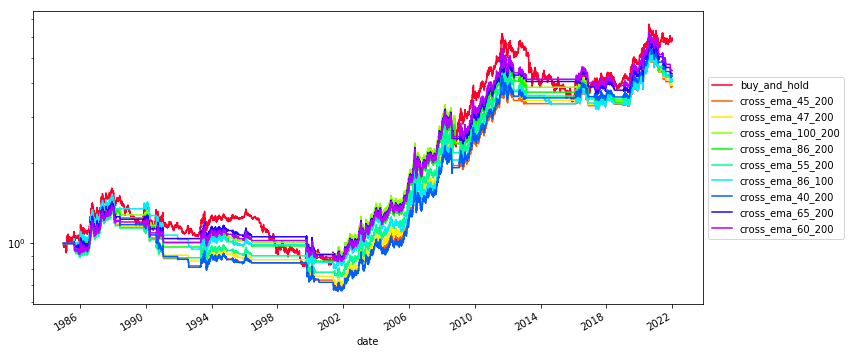

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

highlight_ratio  flip_ratio      accu      prec       mse
cross_ema_45_200          0.307783    0.015098  0.500444  0.480769  1.274444
cross_ema_47_200          0.308079    0.015098  0.501332  0.482229  1.272180
cross_ema_100_200         0.332643    0.018650  0.502811  0.485765  1.262543
cross_ema_86_200          0.323764    0.018058  0.504587  0.488117  1.267705
cross_ema_55_200          0.307487    0.013914  0.503107  0.485082  1.268091
cross_ema_86_100          0.312814    0.014506  0.500148  0.480605  1.270793
cross_ema_40_200          0.309855    0.016282  0.500148  0.480420  1.277123
cross_ema_65_200          0.310743    0.015690  0.505771  0.489524  1.261546
cross_ema_60_200          0.308375    0.014506  0.505179  0.488484  1.260787

annual_return  sharpe_ratio  max_drawdown  avg_drawdown  \
buy_and_hold           -0.042235     -0.283945     -0.481481     -0.272448   
cross_ema_45_200       -0.044394     -0.497919     -0.466126     -0.322949   
cross_ema_47_200       -0.042243     -0.471712     -0.447782     -0.305843   
cross_ema_100_200      -0.032740     -0.376285     -0.367301     -0.251186   
cross_ema_86_200       -0.037726     -0.436223     -0.411084     -0.281418   
cross_ema_55_200       -0.038325     -0.425719     -0.413563     -0.284738   
cross_ema_86_100       -0.040976     -0.452160     -0.437908     -0.283449   
cross_ema_40_200       -0.046948     -0.527522     -0.476519     -0.330496   
cross_ema_65_200       -0.031967     -0.353753     -0.354752     -0.224262   
cross_ema_60_200       -0.031252     -0.343992     -0.348334     -0.222143   

                   return/avgdd  
buy_and_hold          -0.155021  
cross_ema_45_200      -0.137463  
cross_ema_47_200      -0.138119  
cross_ema_100_200     -0.130343  
cross_ema_86_200      -0.134056  
cross_ema_55_200      -0.134596  
cross_ema_86_100      -0.144563  
cross_ema_40_200      -0.142053  
cross_ema_65_200      -0.142542  
cross_ema_60_200      -0.140683

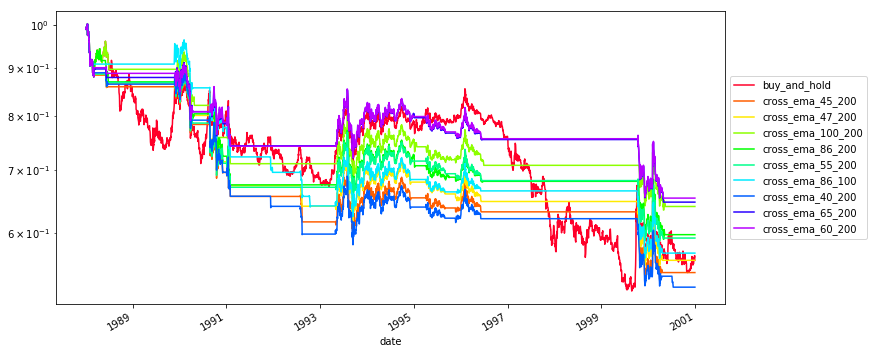

'2001-01-02 00:00:00 to 2005-12-30 00:00:00'

highlight_ratio  flip_ratio      accu      prec       mse
cross_ema_45_200          0.897771    0.030000  0.527287  0.539384  1.212670
cross_ema_47_200          0.897002    0.028462  0.528055  0.539846  1.207147
cross_ema_100_200         0.860876    0.023846  0.530361  0.542857  1.196468
cross_ema_86_200          0.862414    0.023846  0.528824  0.541889  1.199027
cross_ema_55_200          0.886241    0.026923  0.528055  0.540330  1.200992
cross_ema_86_100          0.848578    0.031538  0.521138  0.538043  1.226697
cross_ema_40_200          0.894696    0.030000  0.527287  0.539519  1.214470
cross_ema_65_200          0.872406    0.026923  0.526518  0.540088  1.202053
cross_ema_60_200          0.877786    0.026923  0.528824  0.541156  1.200320

annual_return  sharpe_ratio  max_drawdown  avg_drawdown  \
buy_and_hold            0.132401      0.936292      -0.15445     -0.042569   
cross_ema_45_200        0.109211      0.824163      -0.15445     -0.042893   
cross_ema_47_200        0.116248      0.871062      -0.15445     -0.040225   
cross_ema_100_200       0.130280      0.975800      -0.15445     -0.037008   
cross_ema_86_200        0.126967      0.953345      -0.15445     -0.037171   
cross_ema_55_200        0.124308      0.930681      -0.15445     -0.038364   
cross_ema_86_100        0.092029      0.722954      -0.15445     -0.054558   
cross_ema_40_200        0.106905      0.808010      -0.15445     -0.043566   
cross_ema_65_200        0.122992      0.923739      -0.15445     -0.038476   
cross_ema_60_200        0.125199      0.937576      -0.15445     -0.038331   

                   return/avgdd  
buy_and_hold           3.110238  
cross_ema_45_200       2.546149  
cross_ema_47_200       2.889964  
cross_ema_100_200      3.520297  
cross_ema_86_200       3.415739  
cross_ema_55_200       3.240213  
cross_ema_86_100       1.686822  
cross_ema_40_200       2.453847  
cross_ema_65_200       3.196579  
cross_ema_60_200       3.266253

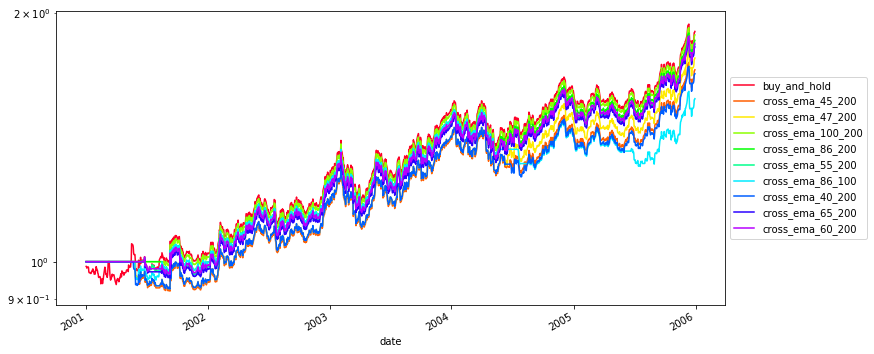

'2006-01-03 00:00:00 to 2008-12-31 00:00:00'

highlight_ratio  flip_ratio      accu      prec       mse
cross_ema_45_200          0.882202    0.011538  0.526248  0.532656  1.216813
cross_ema_47_200          0.883483    0.011538  0.524968  0.531884  1.219379
cross_ema_100_200         0.930858    0.011538  0.516005  0.525447  1.234538
cross_ema_86_200          0.928297    0.011538  0.518566  0.526897  1.223736
cross_ema_55_200          0.886044    0.011538  0.522407  0.530347  1.221443
cross_ema_86_100          0.852753    0.014103  0.519846  0.530030  1.221195
cross_ema_40_200          0.878361    0.011538  0.527529  0.533528  1.215059
cross_ema_65_200          0.889885    0.011538  0.521127  0.529496  1.225299
cross_ema_60_200          0.888604    0.011538  0.522407  0.530259  1.220016

annual_return  sharpe_ratio  max_drawdown  avg_drawdown  \
buy_and_hold            0.186867      0.824008     -0.290117     -0.090528   
cross_ema_45_200        0.159176      0.842807     -0.222369     -0.089220   
cross_ema_47_200        0.153385      0.816955     -0.222369     -0.090620   
cross_ema_100_200       0.113368      0.586149     -0.279944     -0.094694   
cross_ema_86_200        0.137494      0.684958     -0.254214     -0.091473   
cross_ema_55_200        0.148769      0.796564     -0.222369     -0.091705   
cross_ema_86_100        0.149800      0.807546     -0.222369     -0.099804   
cross_ema_40_200        0.163185      0.861111     -0.222369     -0.088246   
cross_ema_65_200        0.140009      0.755528     -0.225192     -0.093639   
cross_ema_60_200        0.151928      0.810116     -0.222369     -0.090974   

                   return/avgdd  
buy_and_hold           2.064197  
cross_ema_45_200       1.784079  
cross_ema_47_200       1.692618  
cross_ema_100_200      1.197206  
cross_ema_86_200       1.503106  
cross_ema_55_200       1.622245  
cross_ema_86_100       1.500952  
cross_ema_40_200       1.849207  
cross_ema_65_200       1.495201  
cross_ema_60_200       1.670010

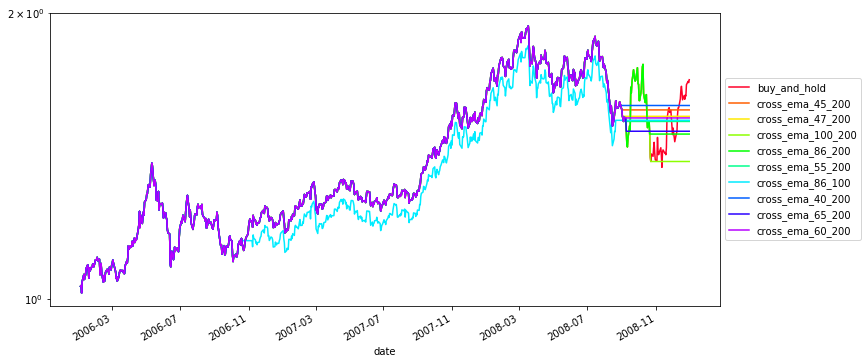

'2009-01-01 00:00:00 to 2011-12-30 00:00:00'

highlight_ratio  flip_ratio      accu      prec       mse
cross_ema_45_200          0.976982    0.003841  0.553708  0.556283  1.190520
cross_ema_47_200          0.975703    0.003841  0.552430  0.555701  1.191654
cross_ema_100_200         0.966752    0.003841  0.551151  0.555556  1.192426
cross_ema_86_200          0.969309    0.003841  0.553708  0.556728  1.191428
cross_ema_55_200          0.974425    0.003841  0.553708  0.556430  1.190189
cross_ema_86_100          0.971867    0.003841  0.553708  0.556579  1.192710
cross_ema_40_200          0.978261    0.003841  0.554987  0.556863  1.179924
cross_ema_65_200          0.971867    0.003841  0.553708  0.556579  1.192710
cross_ema_60_200          0.973146    0.003841  0.554987  0.557162  1.187445

annual_return  sharpe_ratio  max_drawdown  avg_drawdown  \
buy_and_hold            0.203590      1.084884     -0.186157     -0.044423   
cross_ema_45_200        0.195249      1.078108     -0.186157     -0.043614   
cross_ema_47_200        0.193243      1.068887     -0.186157     -0.043614   
cross_ema_100_200       0.192267      1.073354     -0.186157     -0.043418   
cross_ema_86_200        0.194031      1.081582     -0.186157     -0.043418   
cross_ema_55_200        0.195849      1.081223     -0.186157     -0.043597   
cross_ema_86_100        0.191526      1.064357     -0.186157     -0.043581   
cross_ema_40_200        0.213744      1.152119     -0.186157     -0.043614   
cross_ema_65_200        0.191526      1.064357     -0.186157     -0.043581   
cross_ema_60_200        0.200761      1.104760     -0.186157     -0.043581   

                   return/avgdd  
buy_and_hold           4.583029  
cross_ema_45_200       4.476771  
cross_ema_47_200       4.430780  
cross_ema_100_200      4.428310  
cross_ema_86_200       4.468949  
cross_ema_55_200       4.492298  
cross_ema_86_100       4.394758  
cross_ema_40_200       4.900819  
cross_ema_65_200       4.394758  
cross_ema_60_200       4.606670

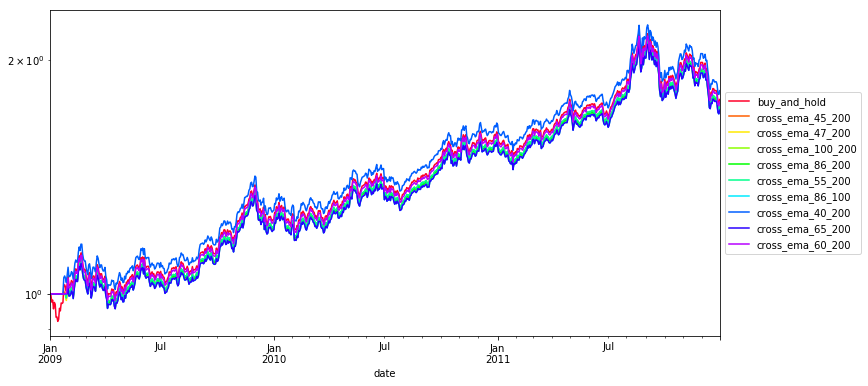

'2012-01-02 00:00:00 to 2015-12-31 00:00:00'

highlight_ratio  flip_ratio      accu      prec       mse
cross_ema_45_200          0.201536    0.002882  0.521113  0.514286  1.220607
cross_ema_47_200          0.202495    0.002882  0.520154  0.511848  1.223356
cross_ema_100_200         0.226488    0.002882  0.513436  0.495763  1.229415
cross_ema_86_200          0.216891    0.002882  0.511516  0.491150  1.236375
cross_ema_55_200          0.205374    0.002882  0.517274  0.504673  1.229269
cross_ema_86_100          0.237044    0.008646  0.516315  0.502024  1.227757
cross_ema_40_200          0.199616    0.002882  0.523033  0.519231  1.216691
cross_ema_65_200          0.207294    0.002882  0.517274  0.504630  1.226488
cross_ema_60_200          0.205374    0.002882  0.515355  0.500000  1.230687

annual_return  sharpe_ratio  max_drawdown  avg_drawdown  \
buy_and_hold           -0.089555     -0.494734     -0.412616     -0.229167   
cross_ema_45_200       -0.004158     -0.037034     -0.140874     -0.124982   
cross_ema_47_200       -0.007714     -0.094217     -0.153488     -0.136549   
cross_ema_100_200      -0.015926     -0.197006     -0.196433     -0.155561   
cross_ema_86_200       -0.024468     -0.347374     -0.215937     -0.180212   
cross_ema_55_200       -0.015304     -0.215366     -0.178174     -0.156757   
cross_ema_86_100       -0.013519     -0.177824     -0.178877     -0.124662   
cross_ema_40_200        0.000913      0.045597     -0.131425     -0.110119   
cross_ema_65_200       -0.011817     -0.155633     -0.166387     -0.145408   
cross_ema_60_200       -0.017104     -0.244782     -0.184368     -0.162127   

                   return/avgdd  
buy_and_hold          -0.390783  
cross_ema_45_200      -0.033272  
cross_ema_47_200      -0.056496  
cross_ema_100_200     -0.102380  
cross_ema_86_200      -0.135772  
cross_ema_55_200      -0.097629  
cross_ema_86_100      -0.108442  
cross_ema_40_200       0.008289  
cross_ema_65_200      -0.081265  
cross_ema_60_200      -0.105498

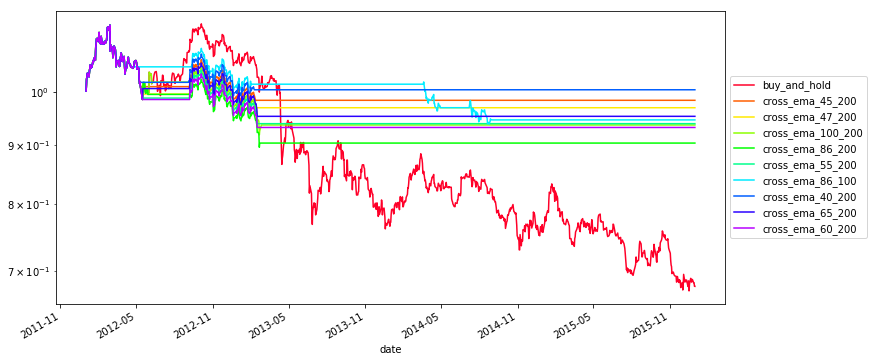

'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  flip_ratio      accu      prec       mse
cross_ema_45_200          0.734485    0.006402  0.509917  0.531359  1.267514
cross_ema_47_200          0.733205    0.006402  0.509917  0.531414  1.269350
cross_ema_100_200         0.740243    0.007682  0.504159  0.527226  1.280673
cross_ema_86_200          0.730646    0.006402  0.504798  0.528021  1.272846
cross_ema_55_200          0.730646    0.006402  0.506078  0.528897  1.271023
cross_ema_86_100          0.699296    0.006402  0.511836  0.534309  1.259601
cross_ema_40_200          0.733205    0.008323  0.511196  0.532286  1.261086
cross_ema_65_200          0.729367    0.006402  0.499680  0.524561  1.279780
cross_ema_60_200          0.730006    0.006402  0.502879  0.526731  1.278549

annual_return  sharpe_ratio  max_drawdown  avg_drawdown  \
buy_and_hold            0.091659      0.718013     -0.185126     -0.066784   
cross_ema_45_200        0.024113      0.257484     -0.275674     -0.095271   
cross_ema_47_200        0.022137      0.241805     -0.275674     -0.094658   
cross_ema_100_200       0.009772      0.140951     -0.241979     -0.119447   
cross_ema_86_200        0.018336      0.211044     -0.242102     -0.109939   
cross_ema_55_200        0.020353      0.227653     -0.275672     -0.103157   
cross_ema_86_100        0.033147      0.334672     -0.233503     -0.091457   
cross_ema_40_200        0.031238      0.315479     -0.263394     -0.090247   
cross_ema_65_200        0.010813      0.149588     -0.278633     -0.111704   
cross_ema_60_200        0.012189      0.160994     -0.290566     -0.107079   

                   return/avgdd  
buy_and_hold           1.372467  
cross_ema_45_200       0.253100  
cross_ema_47_200       0.233864  
cross_ema_100_200      0.081813  
cross_ema_86_200       0.166781  
cross_ema_55_200       0.197298  
cross_ema_86_100       0.362428  
cross_ema_40_200       0.346138  
cross_ema_65_200       0.096800  
cross_ema_60_200       0.113832

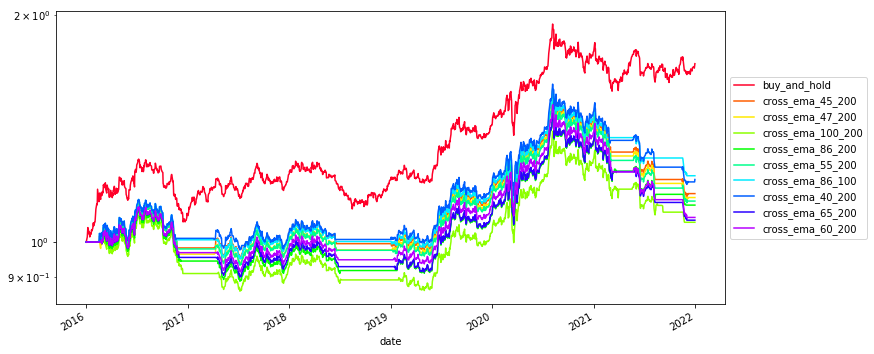

['buy_and_hold',
 'cross_ema_45_200',
 'cross_ema_47_200',
 'cross_ema_100_200',
 'cross_ema_86_200',
 'cross_ema_55_200',
 'cross_ema_86_100',
 'cross_ema_40_200',
 'cross_ema_65_200',
 'cross_ema_60_200']

In [52]:
strategy_list_sel = print_all_result(ret_ema)

print_all_result(ret_ema['1988':'2000'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_ema['2001':'2005'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_ema['2006':'2008'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_ema['2009':'2011'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_ema['2012':'2015'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_ema['2016':'2021'], strategy_list_sel=strategy_list_sel)

In [53]:
pred_all = pd.DataFrame()
proba_all = pd.DataFrame()

In [54]:
cases = ['vote_c3ema_rollM_lookback5_top1']
cross3ema_nofuture = pd.read_csv('output_others/prob_sub_cross_3ema_rolling_extend_ll.csv', index_col=0)
cross3ema_nofuture.index = pd.to_datetime(cross3ema_nofuture.index)
cross3ema_nofuture = cross3ema_nofuture[start:end]
# cross3ema_nofuture.columns = ["{} (no future)".format(col) for col in cross3ema_nofuture.columns]
cross3ema_nofuture = cross3ema_nofuture[cases]
pred_all = pd.concat([pred_all, cross3ema_nofuture], axis=1)

cross3ema_nofuture_proba = pd.read_csv('output_others/prob_sub_cross_3ema_rolling_extend_ll.csv', index_col=0)
cross3ema_nofuture_proba.index = pd.to_datetime(cross3ema_nofuture_proba.index)
cross3ema_nofuture_proba = cross3ema_nofuture_proba[start:end]
# cross3ema_nofuture.columns = ["{} (no future)".format(col) for col in cross3ema_nofuture.columns]
cross3ema_nofuture_proba = cross3ema_nofuture_proba[cases]
proba_all = pd.concat([proba_all, cross3ema_nofuture_proba], axis=1)

In [55]:
cases = ['vote_lookbackA_rollA_top20']
vote_lookback_nofuture = pd.read_csv('output_others/vote_lookback_without_c3ema.csv', index_col=0)
vote_lookback_nofuture.index = pd.to_datetime(vote_lookback_nofuture.index)
vote_lookback_nofuture = vote_lookback_nofuture[start:end]
vote_lookback_nofuture = vote_lookback_nofuture[cases]
pred_all = pd.concat([pred_all, vote_lookback_nofuture], axis=1)

vote_lookback_nofuture_proba = pd.read_csv('output_others/vote_lookback_without_c3ema_proba.csv', index_col=0)
vote_lookback_nofuture_proba.index = pd.to_datetime(vote_lookback_nofuture_proba.index)
vote_lookback_nofuture_proba = vote_lookback_nofuture_proba[start:end]
vote_lookback_nofuture_proba = vote_lookback_nofuture_proba[cases]
proba_all = pd.concat([proba_all, vote_lookback_nofuture_proba], axis=1)

In [56]:
proba_all = proba_all.fillna(1.0)
pred_all = pred_all.fillna(1.0)

In [57]:
pred_all['buy_and_hold'] = 1
pred_all['true_up'] = true_up.astype(int)
proba_all['buy_and_hold'] = 1
proba_all['true_up'] = 1

In [58]:
combine_cases = ['vote_lookbackA_rollA_top20', 'vote_c3ema_rollM_lookback5_top1']
proba_all['equal_weight_combine'] = proba_all[combine_cases].mean(axis=1)
pred_all['equal_weight_combine'] = (proba_all['equal_weight_combine']>=0.5).astype(int)
proba_all['biased1_combine'] = pred_all[combine_cases].mean(axis=1)
proba_all['biased0_combine'] = pred_all[combine_cases].mean(axis=1)
pred_all['biased1_combine'] = (proba_all['biased1_combine'] != 0).astype(int)
pred_all['biased0_combine'] = (proba_all['biased0_combine'] == 1).astype(int)

recal_number = pd.DataFrame()
total_number = 0
for case in combine_cases:
    case_number = case.split("_")[-1]
    case_number = case_number.replace('top', "")
    case_number = int(case_number)
    total_number += case_number
    recal_number[case] = proba_all[case] * case_number

proba_all['weight_combine'] = recal_number[combine_cases].sum(axis=1) / total_number
pred_all['weight_combine'] = (proba_all['weight_combine']>=0.5).astype(int)

In [59]:
def smooth_pred_by_flag(pred, flag):
    flag = flag.reindex(pred.index)
    
    """
    p_smooth = pred.copy()
    i_prev = pred.index[0]
    for i in pred.index[1:]:
        if not flag[i]:
            p_smooth[i] = p_smooth[i_prev]
        i_prev = i
    """
    #p_smooth = pd.Series(np.nan, pred.index)
    #p_smooth.loc[flag.values] = p.loc[flag.values]
    
    
    p_smooth = pred*(flag.apply(lambda x: np.nan if not x else 1))
    
    p_smooth[pred.index[0]] = pred[pred.index[0]]
    p_smooth = p_smooth.ffill()
    
    return p_smooth

In [60]:
cases = ['vote_lookbackA_rollA_top20']

In [61]:
pred_case1 = pred_all[cases]

for base_case in pred_case1.columns:
    for s in pred_ema.columns:
        if s == 'buy_and_hold':
            continue
        p_smooth = smooth_pred_by_flag(pred_case1[base_case], pred_ema[s])
        pred_case1[base_case+'_smooth_'+s] = p_smooth
    
pred_case1['buy_and_hold'] = 1
pred_case1

vote_lookbackA_rollA_top20  \
1985-01-02                         1.0   
1985-01-03                         1.0   
1985-01-04                         1.0   
1985-01-07                         1.0   
1985-01-08                         1.0   
...                                ...   
2021-12-27                         0.0   
2021-12-28                         0.0   
2021-12-29                         0.0   
2021-12-30                         0.0   
2021-12-31                         0.0   

            vote_lookbackA_rollA_top20_smooth_cross_ema_20_25  \
1985-01-02                                                1.0   
1985-01-03                                                1.0   
1985-01-04                                                1.0   
1985-01-07                                                1.0   
1985-01-08                                                1.0   
...                                                       ...   
2021-12-27                                                1.0   
2021-12-28                                                0.0   
2021-12-29                                                0.0   
2021-12-30                                                0.0   
2021-12-31                                                0.0   

            vote_lookbackA_rollA_top20_smooth_cross_ema_20_30  \
1985-01-02                                                1.0   
1985-01-03                                                1.0   
1985-01-04                                                1.0   
1985-01-07                                                1.0   
1985-01-08                                                1.0   
...                                                       ...   
2021-12-27                                                0.0   
2021-12-28                                                0.0   
2021-12-29                                                0.0   
2021-12-30                                                0.0   
2021-12-31                                                0.0   

            vote_lookbackA_rollA_top20_smooth_cross_ema_20_35  \
1985-01-02                                                1.0   
1985-01-03                                                1.0   
1985-01-04                                                1.0   
1985-01-07                                                1.0   
1985-01-08                                                1.0   
...                                                       ...   
2021-12-27                                                1.0   
2021-12-28                                                0.0   
2021-12-29                                                0.0   
2021-12-30                                                0.0   
2021-12-31                                                0.0   

            vote_lookbackA_rollA_top20_smooth_cross_ema_20_40  \
1985-01-02                                                1.0   
1985-01-03                                                1.0   
1985-01-04                                                1.0   
1985-01-07                                                1.0   
1985-01-08                                                1.0   
...                                                       ...   
2021-12-27                                                1.0   
2021-12-28                                                0.0   
2021-12-29                                                0.0   
2021-12-30                                                0.0   
2021-12-31                                                0.0   

            vote_lookbackA_rollA_top20_smooth_cross_ema_20_45  \
1985-01-02                                                1.0   
1985-01-03                                                1.0   
1985-01-04                                                1.0   
1985-01-07                                                1.0   
1985-01-08                                                

In [62]:
ret_pred_case1 = pred_case1.multiply(true_ret, 0)
ret_pred_case1.shape

(9612, 107)

In [ ]:
        def pppp():
            df_temp = pd.concat([ret_df[case], proba_df[case]],1,keys=['return','pred prob']).dropna()

    #         df_temp['log return'] = (1+df_temp['return']).apply(math.log)
    #         df_temp['cumulative return'] = (1+df_temp['return']).cumprod()-1
            df_temp['log cumulative return'] = (1+df_temp['return']).cumprod().apply(math.log)

            z_ret = ret_df[case]/ret_df[case].std()
            z_prod = (proba_df[case]-0.5)/proba_df[case].std()
            df_temp['score'] = 3-abs(z_ret-z_prod)

            df_temp = df_temp.reset_index()
            df_temp['date'] = pd.to_datetime(df_temp['index'])
            
#             display(df_temp)
            
            plot_hue = 'pred prob'
        
            cvals  = [0,0.5,1]
            colors = ["red","white","lawngreen"]
            norm = plt.Normalize(min(cvals),max(cvals))
            tuples = list(zip(map(norm,cvals), colors))
            cmap_prob = LinearSegmentedColormap.from_list("", tuples)
            sm_prob = plt.cm.ScalarMappable(cmap=cmap_prob, norm=norm)
            sm_prob.set_array([])
            
            fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,20))
            ax[0] = sns.scatterplot(data=df_temp, x='date', y='log cumulative return', hue=plot_hue,
                                 #hue='score', alpha=0.5, palette=cmap, s=20)
                                 alpha=0.5, palette=cmap_prob, s=dot_size
#                                  cmap=cmap_prob
                                )

            ax[0].set_xlim([df_temp['date'].iloc[0], df_temp['date'].iloc[-1]])
            ax[0].get_legend()#.remove()
#             ax.set_yscale("log")
            ax[0].figure.colorbar(sm_prob)
            ax[0].set_title("{} {}".format(case, plot_hue))
        
#             proba_df.loc[ret_df.index, case].plot(kind='bar', ax=ax[1])
            ax[1].plot(proba_df['date'], proba_df[case])
            ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax[1].set_title(case + ' proba')
            plt.show()

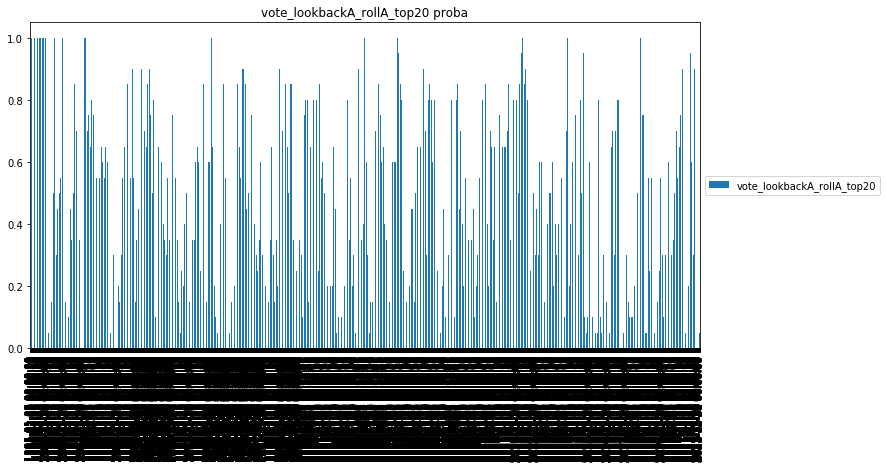

In [64]:
for case in cases:
    fig, ax = plt.subplots(figsize=(12,6))
    proba_all.loc[:, case].plot(kind='bar', ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(case + ' proba')
    plt.show()

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  \
vote_lookbackA_rollA_top20                                 0.490012   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100         0.495630   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55          0.477424   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60          0.479921   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200         0.463587   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73          0.488140   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86          0.487724   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86          0.501248   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100         0.480961   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100         0.485019   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86          0.485539   

                                                    flip_ratio      accu  \
vote_lookbackA_rollA_top20                            0.126834  0.504890   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100    0.084799  0.503225   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55     0.081053  0.508947   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60     0.080845  0.509363   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200    0.084591  0.502601   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73     0.084591  0.505514   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86     0.084591  0.505514   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86     0.084799  0.504890   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100    0.084591  0.505202   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100    0.085423  0.505514   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86     0.085007  0.505618   

                                                        prec       mse  
vote_lookbackA_rollA_top20                          0.522293  1.237725  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100  0.520361  1.227207  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55   0.527130  1.225187  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60   0.527423  1.224680  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200  0.521095  1.230325  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73   0.523018  1.225851  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86   0.523038  1.225794  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86   0.521793  1.225266  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100  0.523037  1.224682  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100  0.523166  1.224238  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86   0.523248  1.222667

annual_return  \
buy_and_hold                                             0.047776   
vote_lookbackA_rollA_top20                               0.040238   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100       0.053129   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55        0.055327   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60        0.055948   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200       0.050181   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73        0.054965   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86        0.055041   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86        0.055686   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100       0.056448   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100       0.057037   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86        0.059044   

                                                    sharpe_ratio  \
buy_and_hold                                            0.378081   
vote_lookbackA_rollA_top20                              0.424901   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100      0.517336   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55       0.522950   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60       0.526888   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200      0.529054   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73       0.535172   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86       0.535874   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86       0.539961   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100      0.546423   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100      0.551774   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86       0.567186   

                                                    max_drawdown  \
buy_and_hold                                           -0.493126   
vote_lookbackA_rollA_top20                             -0.334195   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.304541   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.371382   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.371382   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.299983   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.299952   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.299952   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.304541   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.293563   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.297252   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.293563   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.224901      0.212431  
vote_lookbackA_rollA_top20                             -0.136446      0.294903  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.101088      0.525575  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.104436      0.529765  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.092453      0.605151  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.098430      0.509814  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.094235      0.583273  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.094718      0.581105  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.092874      0.599583  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.094345      0.598313  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.092633      0.615729  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.090176      0.654758

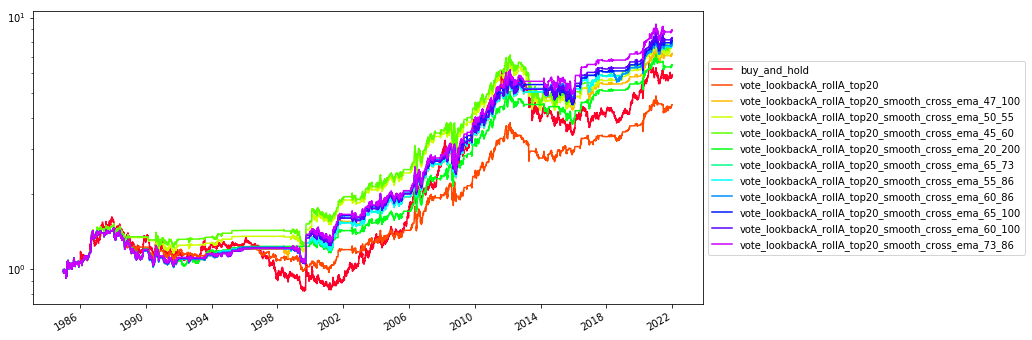

==================================== buy_and_hold


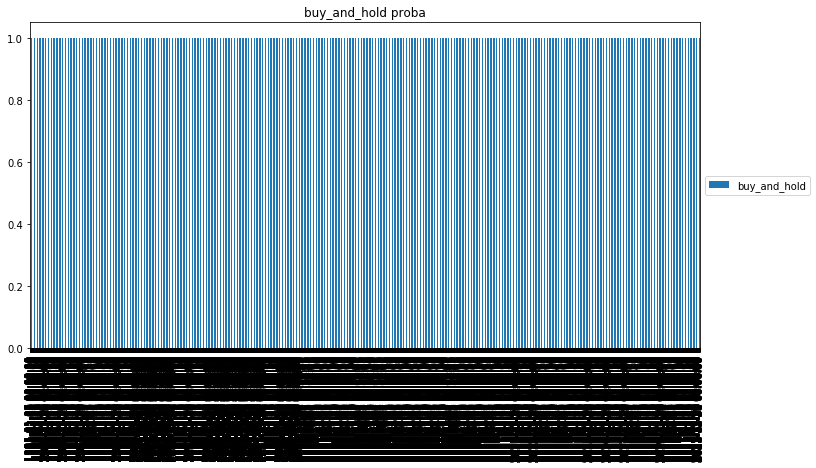

==================================== vote_lookbackA_rollA_top20


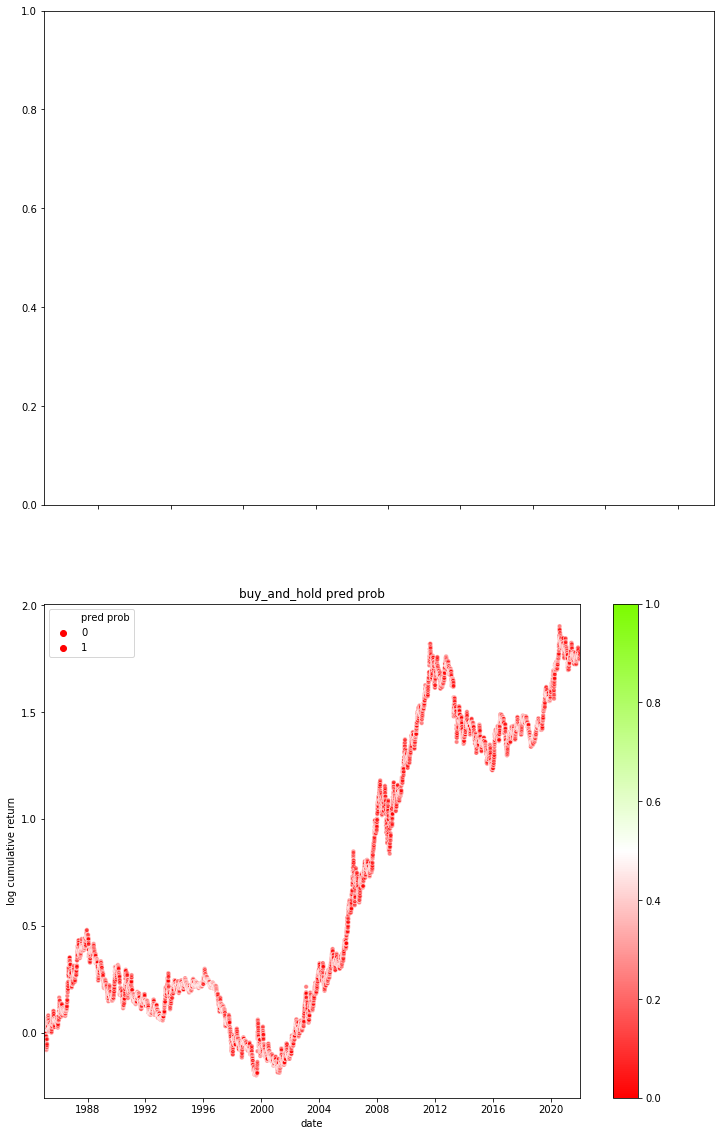

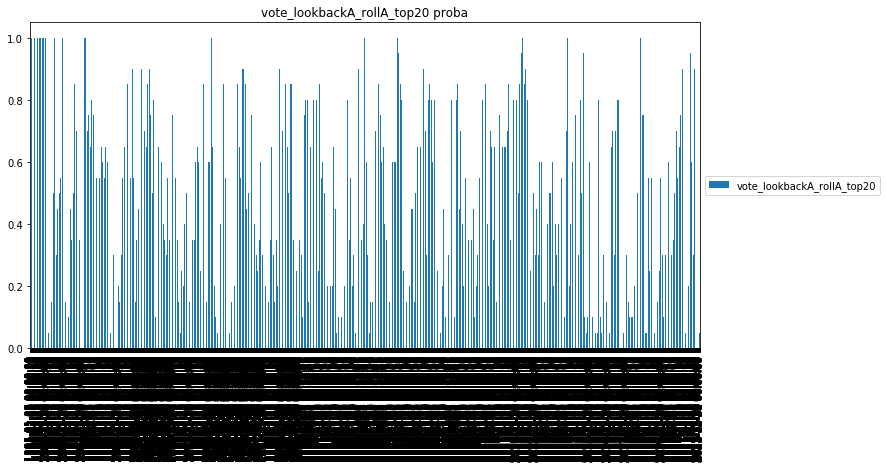

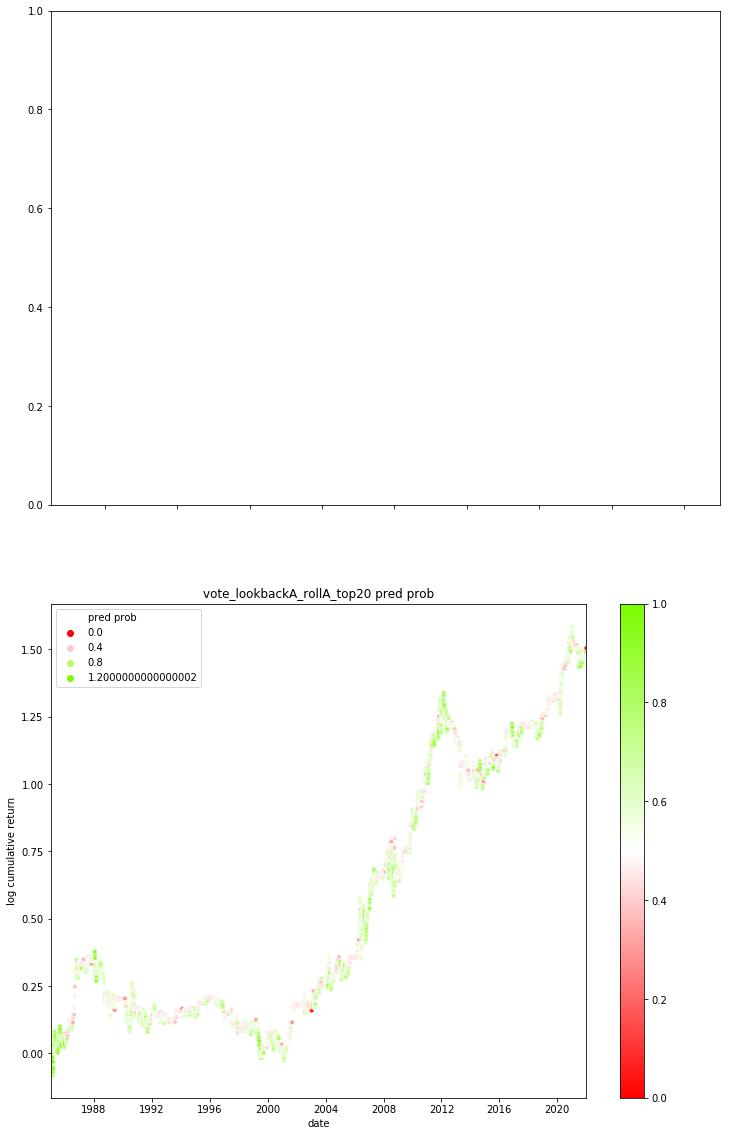

In [81]:
strategy_list_sel = print_all_result(ret_pred_case1, proba_all, base_case=cases, strategy_list_sel=strategy_list_sel)

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  \
vote_lookbackA_rollA_top20                                 0.490012   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100         0.495630   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55          0.477424   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60          0.479921   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200         0.463587   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73          0.488140   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86          0.487724   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86          0.501248   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100         0.480961   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100         0.485019   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86          0.485539   

                                                    flip_ratio      accu  \
vote_lookbackA_rollA_top20                            0.126834  0.504890   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100    0.084799  0.503225   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55     0.081053  0.508947   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60     0.080845  0.509363   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200    0.084591  0.502601   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73     0.084591  0.505514   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86     0.084591  0.505514   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86     0.084799  0.504890   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100    0.084591  0.505202   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100    0.085423  0.505514   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86     0.085007  0.505618   

                                                        prec       mse  
vote_lookbackA_rollA_top20                          0.522293  1.237725  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100  0.520361  1.227207  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55   0.527130  1.225187  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60   0.527423  1.224680  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200  0.521095  1.230325  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73   0.523018  1.225851  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86   0.523038  1.225794  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86   0.521793  1.225266  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100  0.523037  1.224682  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100  0.523166  1.224238  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86   0.523248  1.222667

annual_return  \
buy_and_hold                                             0.047776   
vote_lookbackA_rollA_top20                               0.040238   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100       0.053129   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55        0.055327   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60        0.055948   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200       0.050181   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73        0.054965   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86        0.055041   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86        0.055686   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100       0.056448   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100       0.057037   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86        0.059044   

                                                    sharpe_ratio  \
buy_and_hold                                            0.378081   
vote_lookbackA_rollA_top20                              0.424901   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100      0.517336   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55       0.522950   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60       0.526888   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200      0.529054   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73       0.535172   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86       0.535874   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86       0.539961   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100      0.546423   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100      0.551774   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86       0.567186   

                                                    max_drawdown  \
buy_and_hold                                           -0.493126   
vote_lookbackA_rollA_top20                             -0.334195   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.304541   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.371382   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.371382   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.299983   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.299952   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.299952   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.304541   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.293563   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.297252   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.293563   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.224901      0.212431  
vote_lookbackA_rollA_top20                             -0.136446      0.294903  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.101088      0.525575  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.104436      0.529765  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.092453      0.605151  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.098430      0.509814  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.094235      0.583273  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.094718      0.581105  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.092874      0.599583  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.094345      0.598313  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.092633      0.615729  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.090176      0.654758

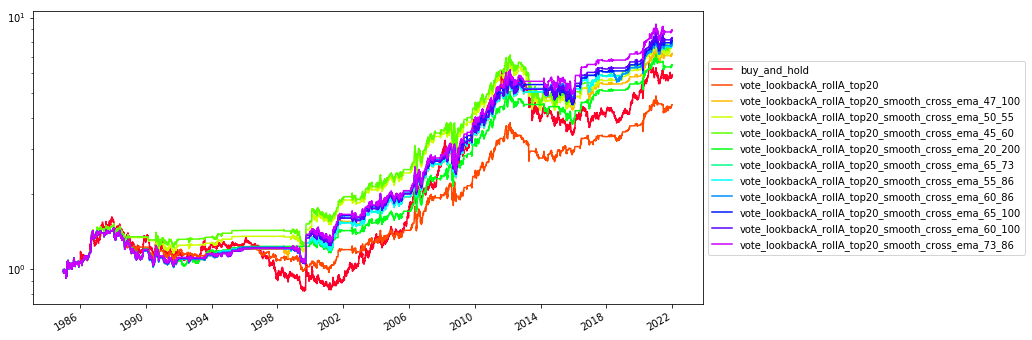

==================================== buy_and_hold


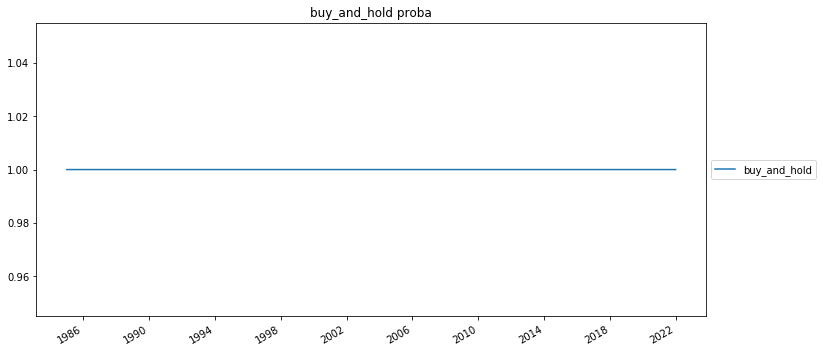

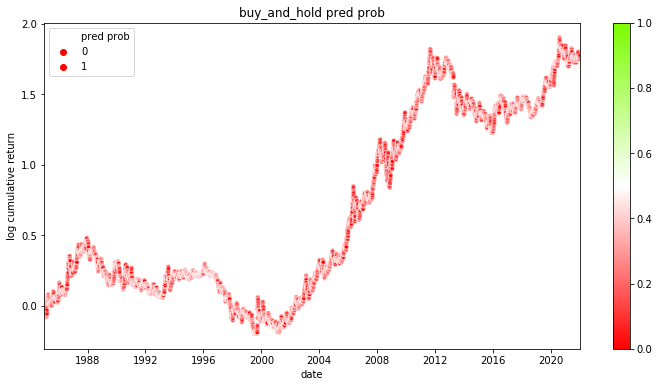

==================================== vote_lookbackA_rollA_top20


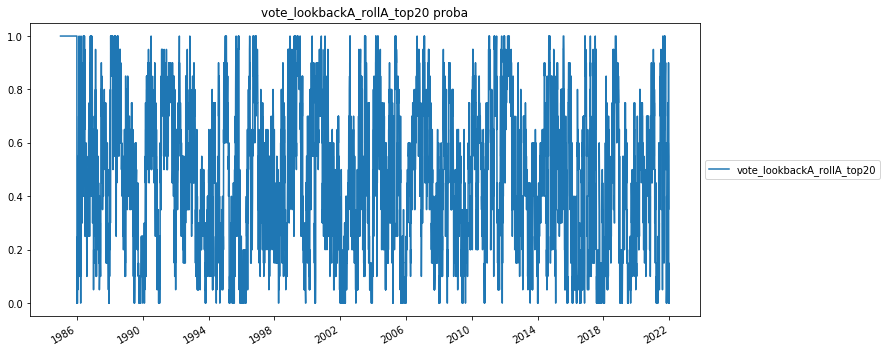

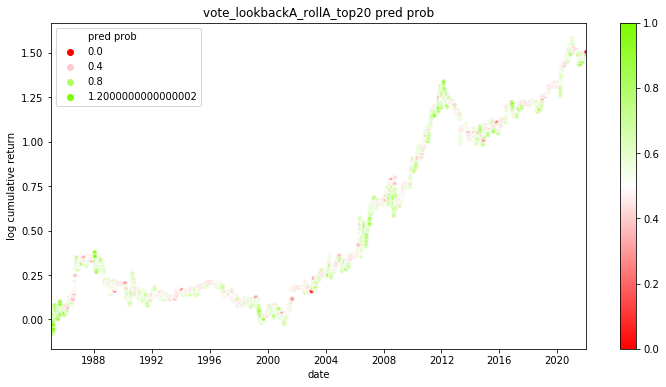

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

highlight_ratio  \
vote_lookbackA_rollA_top20                                 0.517017   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100         0.478840   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55          0.328204   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60          0.337674   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200         0.461083   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73          0.449837   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86          0.449541   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86          0.471441   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100         0.465818   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100         0.465522   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86          0.465818   

                                                    flip_ratio      accu  \
vote_lookbackA_rollA_top20                            0.125518  0.500740   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100    0.056542  0.495117   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55     0.048253  0.508434   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60     0.048253  0.509618   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200    0.058319  0.497484   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73     0.054766  0.501628   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86     0.054766  0.501332   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86     0.055950  0.501924   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100    0.056542  0.503995   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100    0.056542  0.503107   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86     0.056542  0.503995   

                                                        prec       mse  
vote_lookbackA_rollA_top20                          0.488838  1.253208  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100  0.482077  1.236136  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55   0.494139  1.222941  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60   0.496056  1.220459  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200  0.483954  1.239494  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73   0.488158  1.237180  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86   0.487821  1.237441  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86   0.489014  1.233366  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100  0.491105  1.231891  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100  0.490146  1.233944  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86   0.491105  1.231316

annual_return  \
buy_and_hold                                            -0.042235   
vote_lookbackA_rollA_top20                              -0.023533   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100      -0.007772   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55        0.006164   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60        0.008515   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200      -0.010270   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73       -0.008534   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86       -0.008789   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86       -0.004877   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100      -0.003401   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100      -0.005396   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86       -0.002836   

                                                    sharpe_ratio  \
buy_and_hold                                           -0.283945   
vote_lookbackA_rollA_top20                             -0.271225   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.045042   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55       0.117627   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60       0.146410   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.093431   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.058867   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.061911   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.014159   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100      0.002841   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.020961   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86       0.009485   

                                                    max_drawdown  \
buy_and_hold                                           -0.481481   
vote_lookbackA_rollA_top20                             -0.328532   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.304541   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.238475   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.195728   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.299983   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.299952   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.299952   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.304541   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.293563   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.297252   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.293563   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.272448     -0.155021  
vote_lookbackA_rollA_top20                             -0.205708     -0.114399  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.194882     -0.039883  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.127270      0.048432  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.092962      0.091593  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.184602     -0.055632  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.190062     -0.044899  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.191337     -0.045933  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.186528     -0.026144  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.183488     -0.018534  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.188961     -0.028555  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.182923     -0.015506

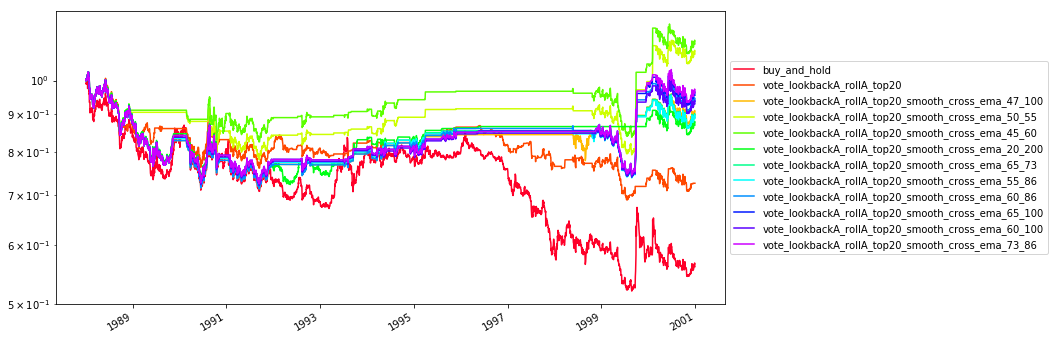

==================================== buy_and_hold


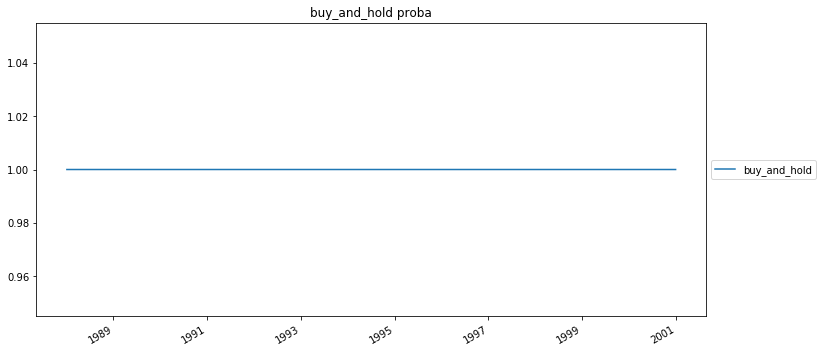

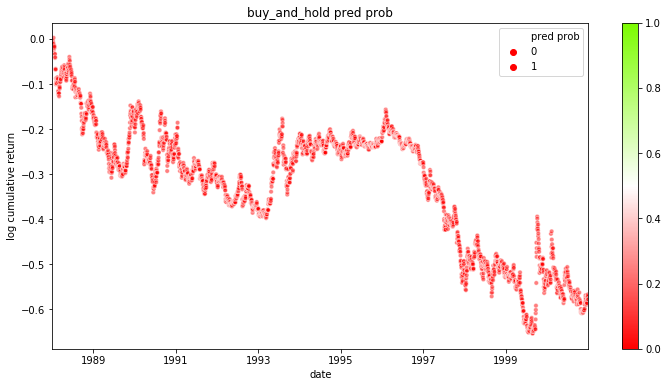

==================================== vote_lookbackA_rollA_top20


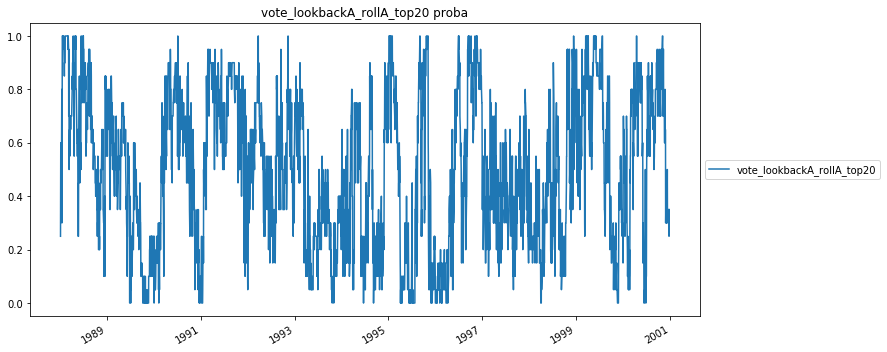

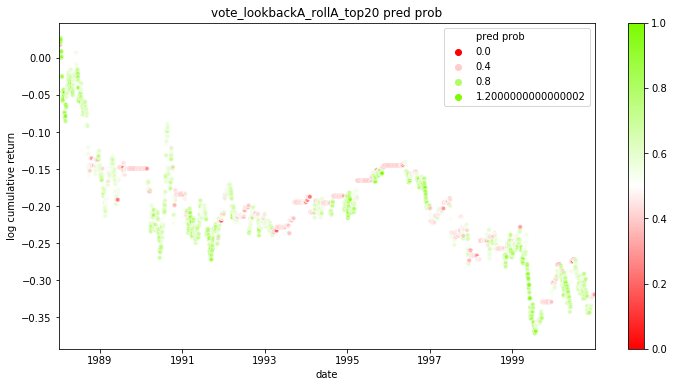

'2001-01-02 00:00:00 to 2005-12-30 00:00:00'

highlight_ratio  \
vote_lookbackA_rollA_top20                                 0.417371   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100         0.458878   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55          0.478862   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60          0.478862   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200         0.438125   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73          0.462721   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86          0.461184   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86          0.461952   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100         0.444274   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100         0.458878   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86          0.459646   

                                                    flip_ratio      accu  \
vote_lookbackA_rollA_top20                            0.151538  0.503459   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100    0.136154  0.504996   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55     0.131538  0.500384   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60     0.131538  0.500384   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200    0.134615  0.496541   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73     0.136154  0.507302   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86     0.136154  0.507302   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86     0.136154  0.506533   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100    0.134615  0.501153   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100    0.137692  0.504996   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86     0.136154  0.504228   

                                                        prec       mse  
vote_lookbackA_rollA_top20                          0.556169  1.252899  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100  0.552764  1.237365  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55   0.545746  1.237914  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60   0.545746  1.237914  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200  0.545614  1.253571  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73   0.554817  1.234585  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86   0.555000  1.234355  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86   0.554077  1.235928  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100  0.550173  1.242344  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100  0.552764  1.237267  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86   0.551839  1.238516

annual_return  \
buy_and_hold                                             0.132401   
vote_lookbackA_rollA_top20                               0.064622   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100       0.083035   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55        0.082436   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60        0.082436   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200       0.063334   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73        0.086456   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86        0.086751   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86        0.084798   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100       0.076997   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100       0.083159   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86        0.081610   

                                                    sharpe_ratio  \
buy_and_hold                                            0.936292   
vote_lookbackA_rollA_top20                              0.706298   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100      0.839419   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55       0.839769   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60       0.839769   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200      0.665787   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73       0.869160   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86       0.872500   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86       0.854478   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100      0.790454   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100      0.840769   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86       0.826199   

                                                    max_drawdown  \
buy_and_hold                                           -0.154450   
vote_lookbackA_rollA_top20                             -0.114507   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.114507   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.114507   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.114507   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.114507   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.114507   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.114507   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.114507   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.114507   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.114507   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.114507   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.042569      3.110238  
vote_lookbackA_rollA_top20                             -0.025840      2.500834  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.025321      3.279298  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.022950      3.591901  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.022950      3.591901  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.027166      2.331371  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.025104      3.443920  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.024944      3.477808  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.025171      3.368909  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.026501      2.905451  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.025065      3.317727  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.025428      3.209467

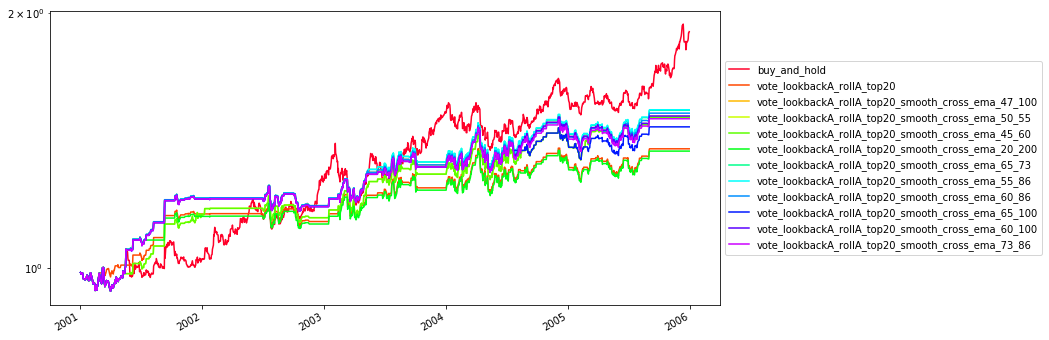

==================================== buy_and_hold


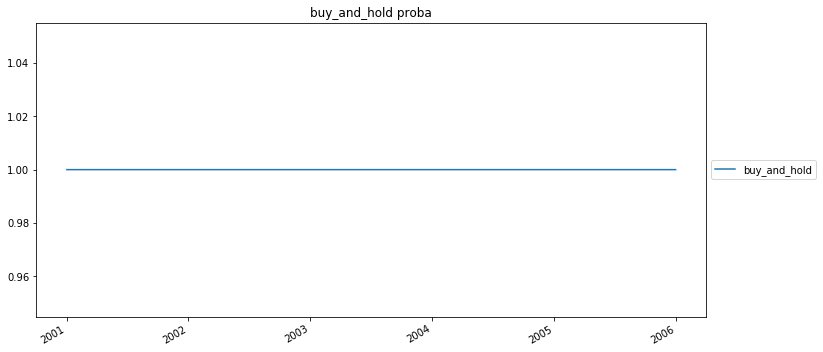

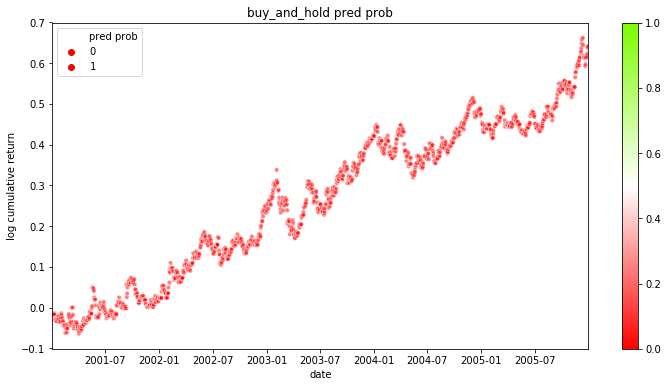

==================================== vote_lookbackA_rollA_top20


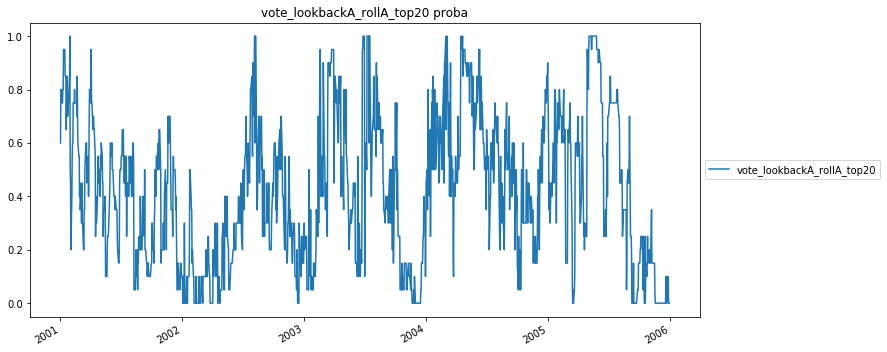

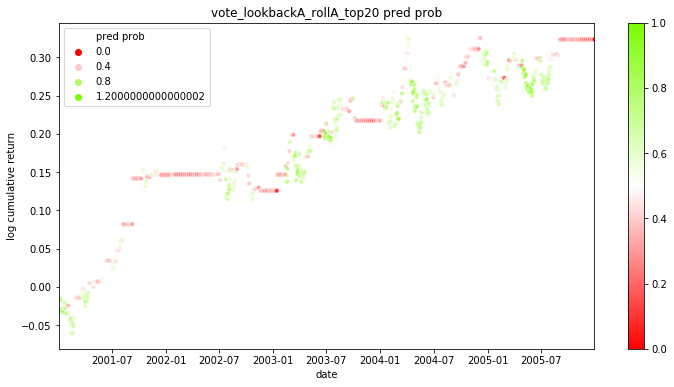

'2006-01-03 00:00:00 to 2008-12-31 00:00:00'

highlight_ratio  \
vote_lookbackA_rollA_top20                                 0.554417   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100         0.615877   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55          0.650448   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60          0.649168   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200         0.533931   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73          0.615877   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86          0.615877   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86          0.615877   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100         0.615877   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100         0.615877   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86          0.615877   

                                                    flip_ratio      accu  \
vote_lookbackA_rollA_top20                            0.117949  0.523688   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100    0.101282  0.528809   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55     0.097436  0.527529   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60     0.097436  0.528809   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200    0.105128  0.526248   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73     0.101282  0.528809   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86     0.101282  0.528809   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86     0.101282  0.528809   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100    0.101282  0.528809   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100    0.101282  0.528809   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86     0.101282  0.528809   

                                                        prec       mse  
vote_lookbackA_rollA_top20                          0.549654  1.242969  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100  0.548857  1.227645  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55   0.545276  1.231315  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60   0.546351  1.229289  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200  0.553957  1.224893  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73   0.548857  1.227645  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86   0.548857  1.227645  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86   0.548857  1.227645  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100  0.548857  1.227645  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100  0.548857  1.227645  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86   0.548857  1.227645

annual_return  \
buy_and_hold                                             0.186867   
vote_lookbackA_rollA_top20                               0.105524   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100       0.134323   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55        0.125356   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60        0.129809   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200       0.147584   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73        0.134323   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86        0.134323   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86        0.134323   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100       0.134323   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100       0.134323   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86        0.134323   

                                                    sharpe_ratio  \
buy_and_hold                                            0.824008   
vote_lookbackA_rollA_top20                              0.640843   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100      0.722362   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55       0.673877   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60       0.693262   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200      0.898025   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73       0.722362   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86       0.722362   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86       0.722362   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100      0.722362   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100      0.722362   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86       0.722362   

                                                    max_drawdown  \
buy_and_hold                                           -0.290117   
vote_lookbackA_rollA_top20                             -0.201061   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.222815   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.232269   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.222815   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.201061   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.222815   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.222815   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.222815   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.222815   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.222815   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.222815   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.090528      2.064197  
vote_lookbackA_rollA_top20                             -0.042987      2.454806  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.044763      3.000741  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.046403      2.701484  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.044573      2.912305  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.034632      4.261535  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.044763      3.000741  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.044763      3.000741  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.044763      3.000741  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.044763      3.000741  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.044763      3.000741  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.044763      3.000741

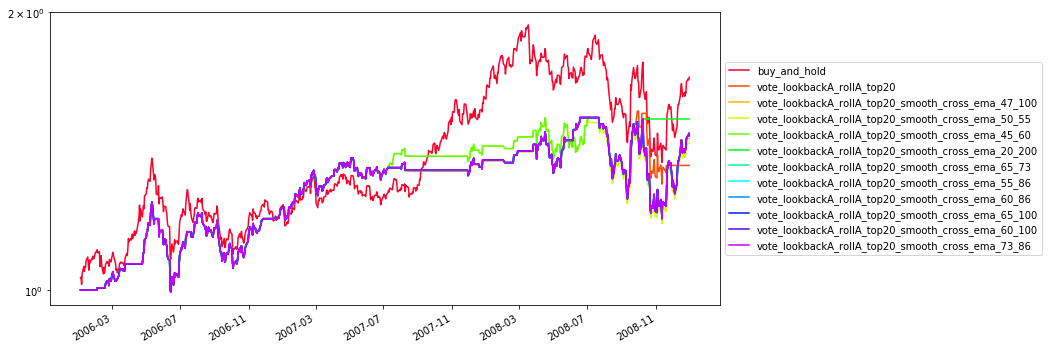

==================================== buy_and_hold


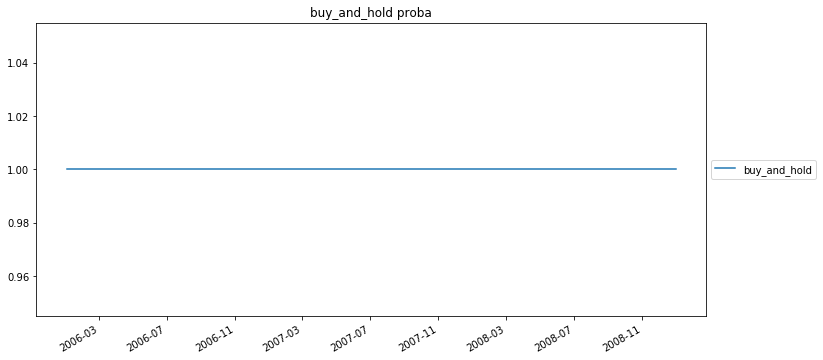

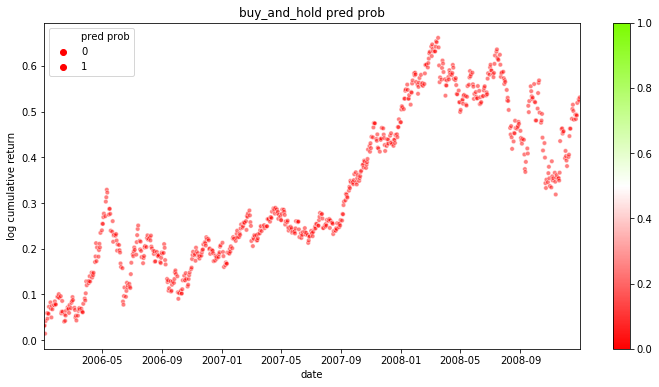

==================================== vote_lookbackA_rollA_top20


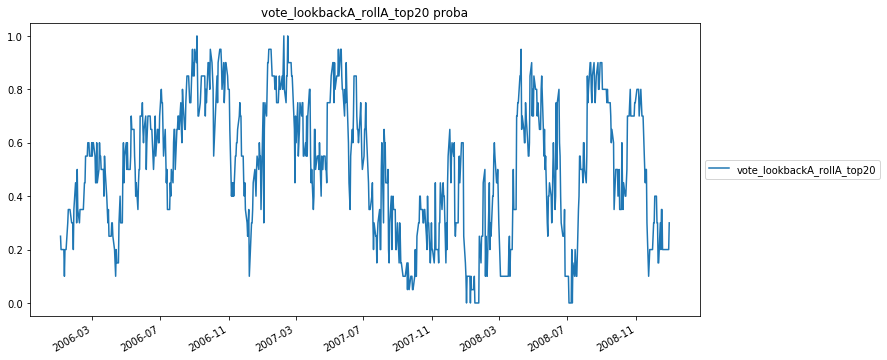

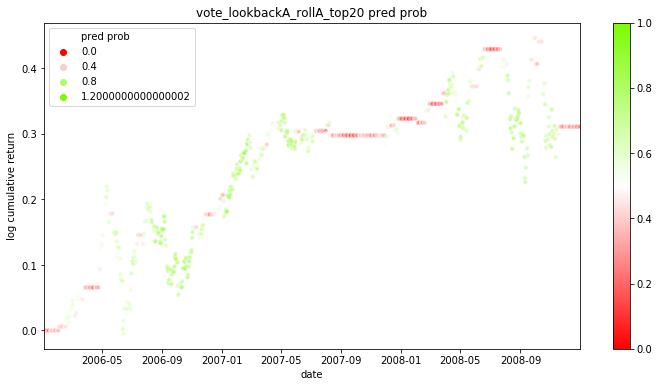

'2009-01-01 00:00:00 to 2011-12-30 00:00:00'

highlight_ratio  \
vote_lookbackA_rollA_top20                                 0.515345   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100         0.516624   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55          0.515345   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60          0.515345   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200         0.515345   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73          0.516624   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86          0.516624   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86          0.520460   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100         0.533248   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100         0.531969   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86          0.533248   

                                                    flip_ratio      accu  \
vote_lookbackA_rollA_top20                            0.107554  0.524297   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100    0.107554  0.525575   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55     0.107554  0.524297   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60     0.107554  0.524297   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200    0.107554  0.524297   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73     0.107554  0.525575   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86     0.107554  0.525575   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86     0.107554  0.524297   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100    0.107554  0.526854   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100    0.107554  0.525575   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86     0.107554  0.526854   

                                                        prec       mse  
vote_lookbackA_rollA_top20                          0.578164  1.200138  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100  0.579208  1.198836  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55   0.578164  1.200138  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60   0.578164  1.200138  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200  0.578164  1.200138  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73   0.579208  1.198836  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86   0.579208  1.198836  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86   0.577396  1.201426  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100  0.577938  1.189425  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100  0.576923  1.200020  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86   0.577938  1.189425

annual_return  \
buy_and_hold                                             0.203590   
vote_lookbackA_rollA_top20                               0.188887   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100       0.191179   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55        0.188887   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60        0.188887   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200       0.188887   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73        0.191179   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86        0.191179   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86        0.186406   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100       0.206625   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100       0.188240   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86        0.206625   

                                                    sharpe_ratio  \
buy_and_hold                                            1.084884   
vote_lookbackA_rollA_top20                              1.482983   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100      1.498413   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55       1.482983   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60       1.482983   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200      1.482983   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73       1.498413   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86       1.498413   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86       1.449979   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100      1.506521   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100      1.417291   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86       1.506521   

                                                    max_drawdown  \
buy_and_hold                                           -0.186157   
vote_lookbackA_rollA_top20                             -0.113766   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.113766   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.113766   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.113766   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.113766   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.113766   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.113766   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.113766   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.113766   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.113766   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.113766   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.044423      4.583029  
vote_lookbackA_rollA_top20                             -0.012949     14.587200  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.012754     14.989236  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.012949     14.587200  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.012949     14.587200  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.012949     14.587200  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.012754     14.989236  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.012754     14.989236  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.013153     14.172453  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.012924     15.988287  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.013307     14.145985  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.012924     15.988287

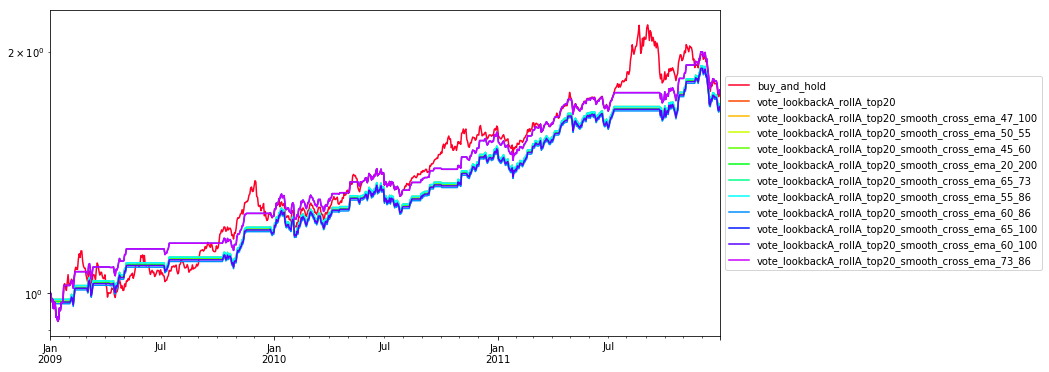

==================================== buy_and_hold


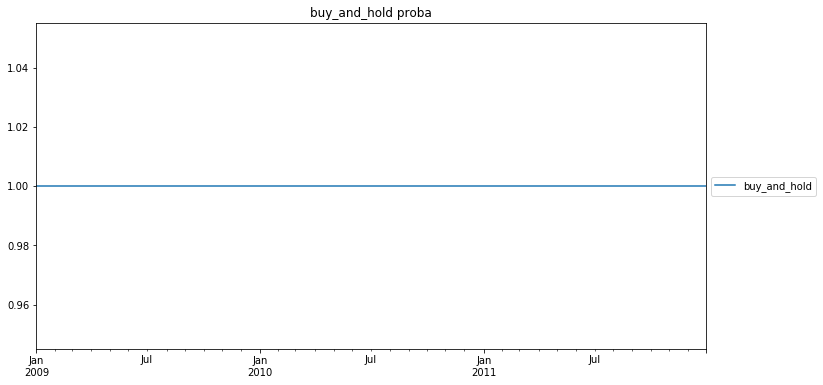

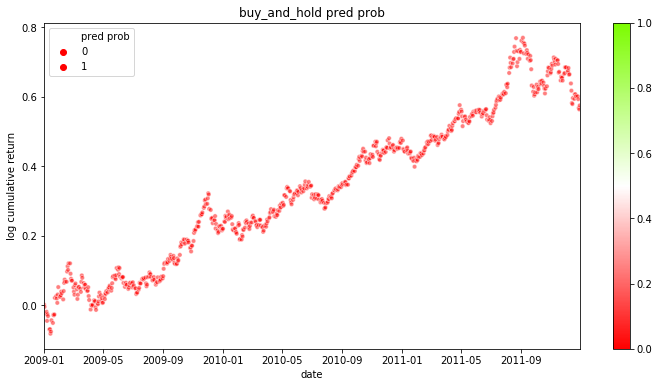

==================================== vote_lookbackA_rollA_top20


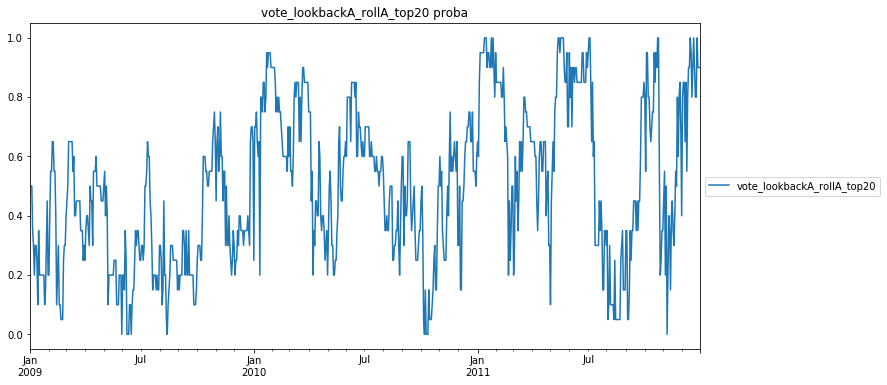

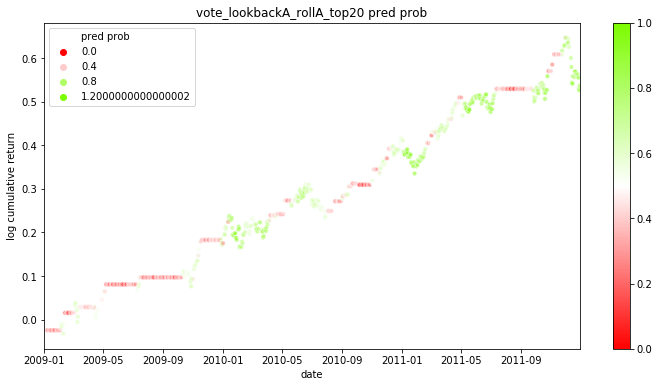

'2012-01-02 00:00:00 to 2015-12-31 00:00:00'

highlight_ratio  \
vote_lookbackA_rollA_top20                                 0.492322   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100         0.572937   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55          0.838772   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60          0.838772   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200         0.500960   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73          0.598848   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86          0.598848   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86          0.599808   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100         0.580614   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100         0.604607   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86          0.605566   

                                                    flip_ratio      accu  \
vote_lookbackA_rollA_top20                            0.124880  0.506718   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100    0.040346  0.491363   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55     0.048031  0.509597   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60     0.048031  0.509597   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200    0.023055  0.494242   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73     0.044188  0.490403   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86     0.044188  0.490403   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86     0.042267  0.491363   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100    0.040346  0.489443   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100    0.042267  0.490403   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86     0.042267  0.489443   

                                                        prec       mse  
vote_lookbackA_rollA_top20                          0.491228  1.237453  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100  0.479062  1.237922  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55   0.496568  1.263512  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60   0.496568  1.263512  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200  0.478927  1.244642  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73   0.479167  1.225108  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86   0.479167  1.225108  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86   0.480000  1.226804  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100  0.477686  1.242143  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100  0.479365  1.228632  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86   0.478605  1.229040

annual_return  \
buy_and_hold                                            -0.089555   
vote_lookbackA_rollA_top20                              -0.030529   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100      -0.030255   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55       -0.067355   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60       -0.067355   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200      -0.037399   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73       -0.014291   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86       -0.014291   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86       -0.016417   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100      -0.035661   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100      -0.018853   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86       -0.019370   

                                                    sharpe_ratio  \
buy_and_hold                                           -0.494734   
vote_lookbackA_rollA_top20                             -0.204333   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.223263   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.372911   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.372911   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.340152   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.071963   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.071963   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.091697   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.269641   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.111714   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.116356   

                                                    max_drawdown  \
buy_and_hold                                           -0.412616   
vote_lookbackA_rollA_top20                             -0.299361   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.235505   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.371382   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.371382   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.258524   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.182105   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.182105   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.189376   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.252973   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.197644   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.199392   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.229167     -0.390783  
vote_lookbackA_rollA_top20                             -0.199546     -0.152991  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.118383     -0.255572  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.240899     -0.279597  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.240899     -0.279597  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.126692     -0.295196  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.094725     -0.150865  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.094725     -0.150865  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.099864     -0.164395  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.123499     -0.288754  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.101443     -0.185845  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.102011     -0.189882

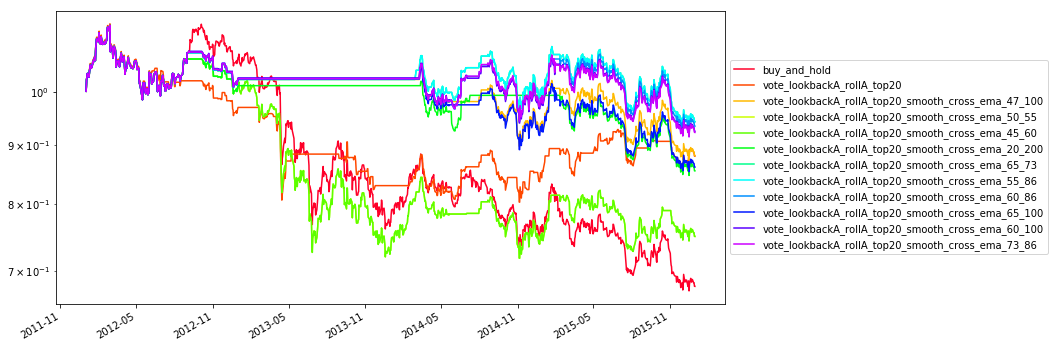

==================================== buy_and_hold


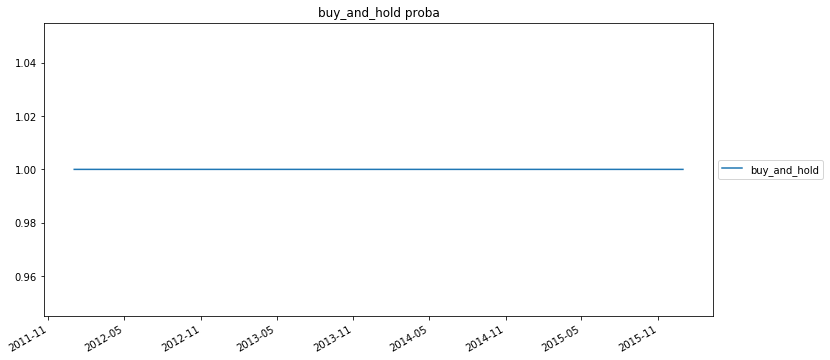

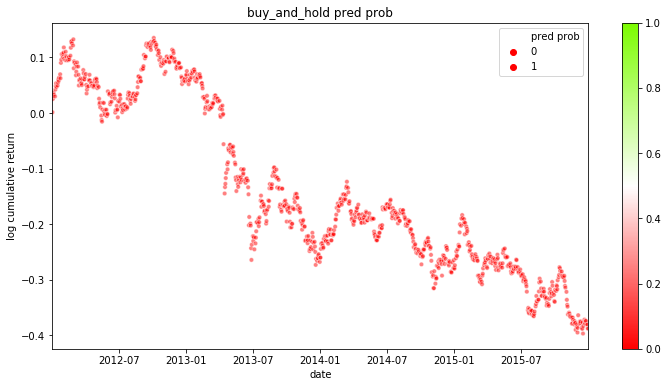

==================================== vote_lookbackA_rollA_top20


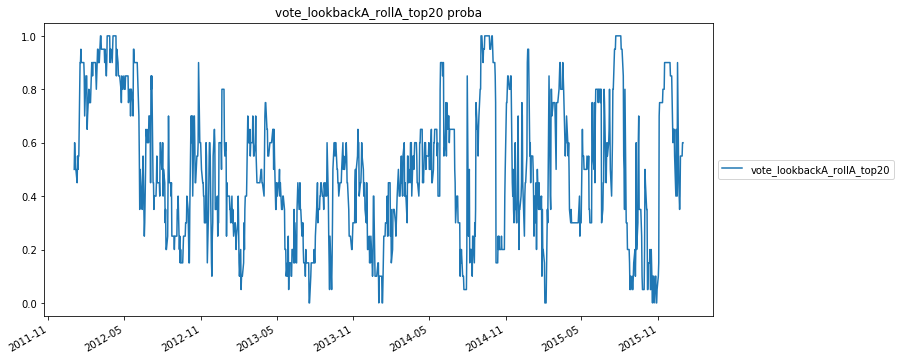

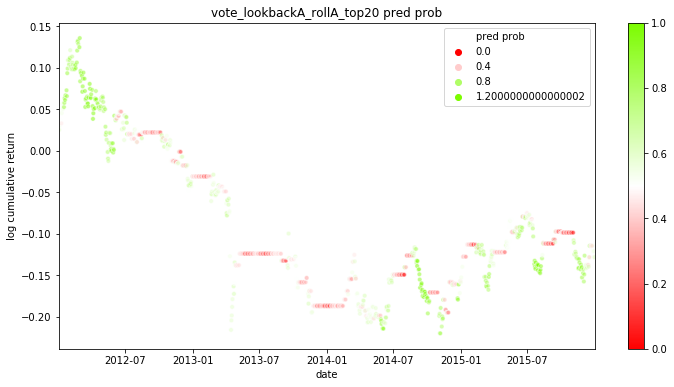

'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  \
vote_lookbackA_rollA_top20                                 0.384517   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100         0.381958   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55          0.371081   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60          0.366603   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200         0.330134   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73          0.378119   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86          0.377479   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86          0.410109   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100         0.318618   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100         0.316699   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86          0.317338   

                                                    flip_ratio      accu  \
vote_lookbackA_rollA_top20                            0.108835  0.505438   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100    0.078745  0.513116   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55     0.076184  0.511196   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60     0.074904  0.510557   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200    0.083867  0.511196   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73     0.078745  0.511836   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86     0.078745  0.512476   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86     0.078745  0.507997   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100    0.078745  0.509917   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100    0.080026  0.510557   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86     0.078745  0.509917   

                                                        prec       mse  
vote_lookbackA_rollA_top20                          0.554077  1.228728  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100  0.564489  1.216496  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55   0.563793  1.208958  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60   0.563700  1.212155  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200  0.571705  1.213667  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73   0.563452  1.217576  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86   0.564407  1.216855  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86   0.553822  1.216702  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100  0.572289  1.205799  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100  0.573737  1.206576  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86   0.572581  1.206605

annual_return  \
buy_and_hold                                             0.091659   
vote_lookbackA_rollA_top20                               0.071581   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100       0.085442   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55        0.094231   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60        0.090516   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200       0.089326   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73        0.084202   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86        0.085041   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86        0.085245   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100       0.098302   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100       0.097393   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86        0.097360   

                                                    sharpe_ratio  \
buy_and_hold                                            0.718013   
vote_lookbackA_rollA_top20                              0.863926   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100      0.987416   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55       1.080055   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60       1.043482   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200      1.104997   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73       0.975584   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86       0.984758   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86       0.989655   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100      1.171582   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100      1.162062   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86       1.161690   

                                                    max_drawdown  \
buy_and_hold                                           -0.185126   
vote_lookbackA_rollA_top20                             -0.143071   
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.137538   
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.137538   
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.137538   
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.132923   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.137538   
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.137538   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.137538   
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.137538   
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.137538   
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.137538   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.066784      1.372467  
vote_lookbackA_rollA_top20                             -0.025895      2.764327  
vote_lookbackA_rollA_top20_smooth_cross_ema_47_100     -0.024526      3.483787  
vote_lookbackA_rollA_top20_smooth_cross_ema_50_55      -0.018840      5.001733  
vote_lookbackA_rollA_top20_smooth_cross_ema_45_60      -0.018975      4.770196  
vote_lookbackA_rollA_top20_smooth_cross_ema_20_200     -0.022159      4.031041  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_73      -0.024349      3.458159  
vote_lookbackA_rollA_top20_smooth_cross_ema_55_86      -0.024340      3.493926  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_86      -0.023897      3.567128  
vote_lookbackA_rollA_top20_smooth_cross_ema_65_100     -0.017285      5.687221  
vote_lookbackA_rollA_top20_smooth_cross_ema_60_100     -0.017273      5.638519  
vote_lookbackA_rollA_top20_smooth_cross_ema_73_86      -0.017291      5.630767

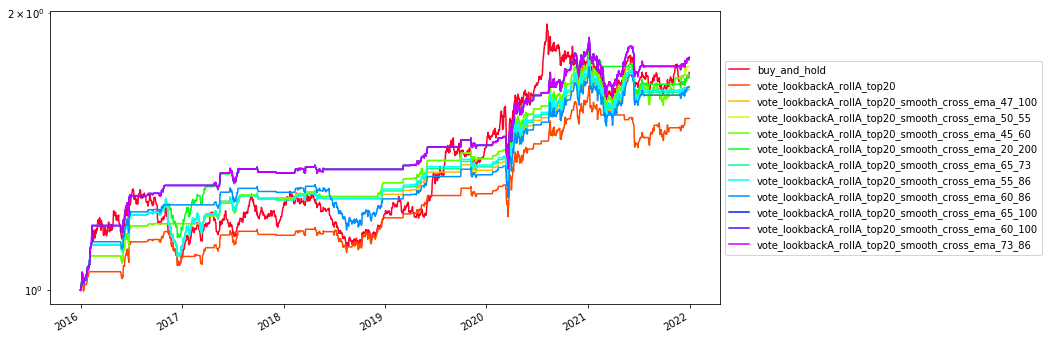

==================================== buy_and_hold


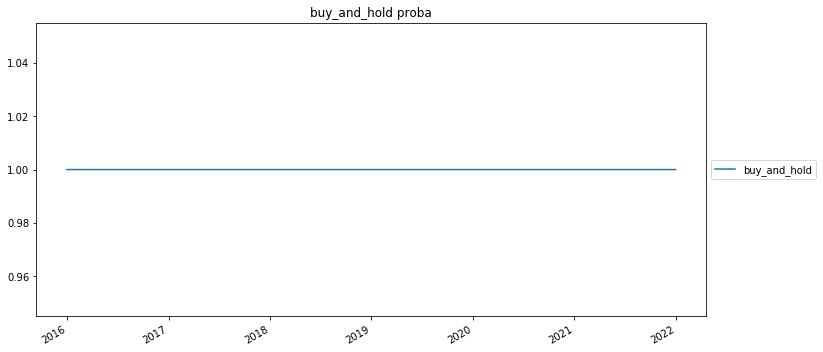

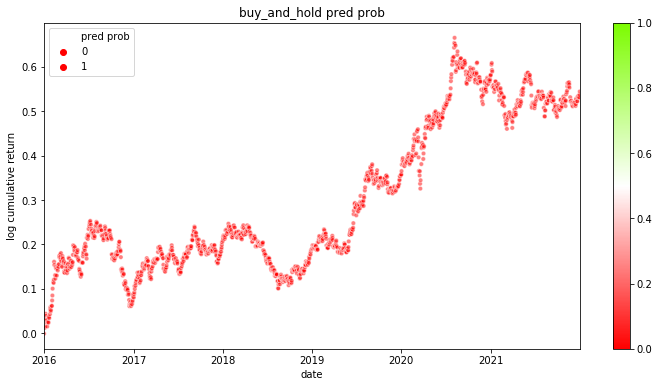

==================================== vote_lookbackA_rollA_top20


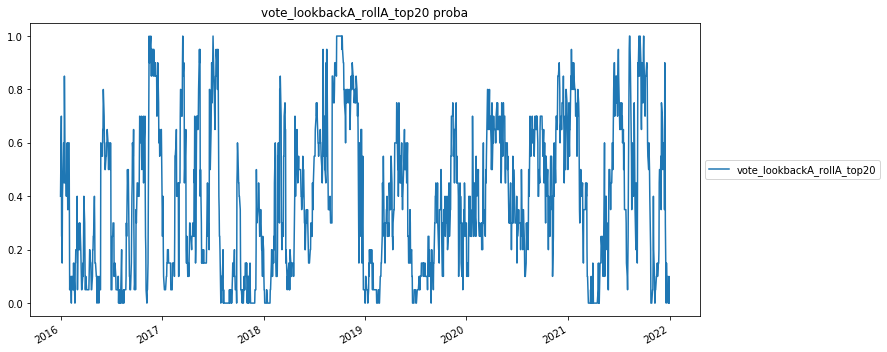

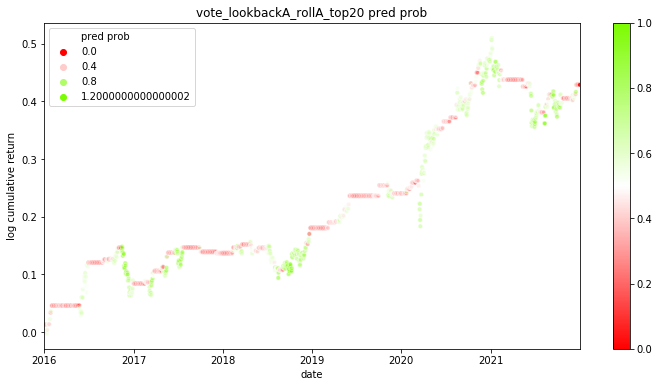

['buy_and_hold',
 'vote_lookbackA_rollA_top20',
 'vote_lookbackA_rollA_top20_smooth_cross_ema_47_100',
 'vote_lookbackA_rollA_top20_smooth_cross_ema_50_55',
 'vote_lookbackA_rollA_top20_smooth_cross_ema_45_60',
 'vote_lookbackA_rollA_top20_smooth_cross_ema_20_200',
 'vote_lookbackA_rollA_top20_smooth_cross_ema_65_73',
 'vote_lookbackA_rollA_top20_smooth_cross_ema_55_86',
 'vote_lookbackA_rollA_top20_smooth_cross_ema_60_86',
 'vote_lookbackA_rollA_top20_smooth_cross_ema_65_100',
 'vote_lookbackA_rollA_top20_smooth_cross_ema_60_100',
 'vote_lookbackA_rollA_top20_smooth_cross_ema_73_86']

In [61]:
# cases = list(ret_pred_all.columns)
# cases.remove('true_up')

# cases = ['vote_lookbackA_rollA_top20', 'biased1_combine', 'buy_and_hold']

strategy_list_sel = print_all_result(ret_pred_case1, proba_all, base_case=cases)

print_all_result(ret_pred_case1['1988':'2000'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case1['2001':'2005'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case1['2006':'2008'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case1['2009':'2011'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case1['2012':'2015'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case1['2016':'2021'], proba_all, strategy_list_sel=strategy_list_sel)

In [62]:
cases = ['biased1_combine']

In [63]:
pred_case2 = pred_all[cases]

for base_case in pred_case2.columns:
    for s in pred_ema.columns:
        if s == 'buy_and_hold':
            continue
        p_smooth = smooth_pred_by_flag(pred_case2[base_case], pred_ema[s])
        pred_case2[base_case+'_smooth_'+s] = p_smooth
    
pred_case2['buy_and_hold'] = 1
pred_case2

biased1_combine  biased1_combine_smooth_cross_ema_20_25  \
1985-01-02                1                                     1.0   
1985-01-03                1                                     1.0   
1985-01-04                1                                     1.0   
1985-01-07                1                                     1.0   
1985-01-08                1                                     1.0   
...                     ...                                     ...   
2021-12-27                0                                     1.0   
2021-12-28                1                                     1.0   
2021-12-29                1                                     1.0   
2021-12-30                1                                     1.0   
2021-12-31                1                                     1.0   

            biased1_combine_smooth_cross_ema_20_30  \
1985-01-02                                     1.0   
1985-01-03                                     1.0   
1985-01-04                                     1.0   
1985-01-07                                     1.0   
1985-01-08                                     1.0   
...                                            ...   
2021-12-27                                     1.0   
2021-12-28                                     1.0   
2021-12-29                                     1.0   
2021-12-30                                     1.0   
2021-12-31                                     1.0   

            biased1_combine_smooth_cross_ema_20_35  \
1985-01-02                                     1.0   
1985-01-03                                     1.0   
1985-01-04                                     1.0   
1985-01-07                                     1.0   
1985-01-08                                     1.0   
...                                            ...   
2021-12-27                                     1.0   
2021-12-28                                     1.0   
2021-12-29                                     1.0   
2021-12-30                                     1.0   
2021-12-31                                     1.0   

            biased1_combine_smooth_cross_ema_20_40  \
1985-01-02                                     1.0   
1985-01-03                                     1.0   
1985-01-04                                     1.0   
1985-01-07                                     1.0   
1985-01-08                                     1.0   
...                                            ...   
2021-12-27                                     1.0   
2021-12-28                                     1.0   
2021-12-29                                     1.0   
2021-12-30                                     1.0   
2021-12-31                                     1.0   

            biased1_combine_smooth_cross_ema_20_45  \
1985-01-02                                     1.0   
1985-01-03                                     1.0   
1985-01-04                                     1.0   
1985-01-07                                     1.0   
1985-01-08                                     1.0   
...                                            ...   
2021-12-27                                     1.0   
2021-12-28                                     1.0   
2021-12-29                                     1.0   
2021-12-30                                     1.0   
2021-12-31                                     1.0   

            biased1_combine_smooth_cross_ema_20_47  \
1985-01-02                                     1.0   
1985-01-03                                     1.0   
1985-01-04                                     1.0   
1985-01-07                                     1.0   
1985-01-08                                     1.0   
...                                            ...   
2021-12-27                                     1.0   
2021-12-28                                     1.0   
2021-12-29                                     1.0   
2021-12-30             

In [64]:
ret_pred_case2 = pred_case2.multiply(true_ret, 0)
ret_pred_case2.shape

(9612, 107)

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  flip_ratio  \
biased1_combine                                 0.817936    0.101342   
biased1_combine_smooth_cross_ema_45_200         0.814503    0.059515   
biased1_combine_smooth_cross_ema_47_200         0.814399    0.059099   
biased1_combine_smooth_cross_ema_60_200         0.816167    0.057018   
biased1_combine_smooth_cross_ema_50_200         0.814919    0.058891   
biased1_combine_smooth_cross_ema_35_200         0.812734    0.059099   
biased1_combine_smooth_cross_ema_25_200         0.751457    0.055978   
biased1_combine_smooth_cross_ema_40_200         0.813878    0.060139   
biased1_combine_smooth_cross_ema_65_100         0.754474    0.056810   
biased1_combine_smooth_cross_ema_60_100         0.772576    0.056394   
biased1_combine_smooth_cross_ema_73_86          0.756970    0.056602   

                                             accu      prec       mse  
biased1_combine                          0.505098  0.513483  1.225670  
biased1_combine_smooth_cross_ema_45_200  0.504578  0.513220  1.221104  
biased1_combine_smooth_cross_ema_47_200  0.504682  0.513286  1.221057  
biased1_combine_smooth_cross_ema_60_200  0.504578  0.513193  1.220933  
biased1_combine_smooth_cross_ema_50_200  0.504786  0.513341  1.220860  
biased1_combine_smooth_cross_ema_35_200  0.506554  0.514465  1.220033  
biased1_combine_smooth_cross_ema_25_200  0.507283  0.516129  1.220889  
biased1_combine_smooth_cross_ema_40_200  0.505618  0.513869  1.219388  
biased1_combine_smooth_cross_ema_65_100  0.510924  0.518478  1.216318  
biased1_combine_smooth_cross_ema_60_100  0.509883  0.517371  1.215668  
biased1_combine_smooth_cross_ema_73_86   0.510508  0.518142  1.215186

annual_return  sharpe_ratio  \
buy_and_hold                                  0.047776      0.378081   
biased1_combine                               0.051139      0.422295   
biased1_combine_smooth_cross_ema_45_200       0.057220      0.464993   
biased1_combine_smooth_cross_ema_47_200       0.057283      0.465463   
biased1_combine_smooth_cross_ema_60_200       0.057416      0.465896   
biased1_combine_smooth_cross_ema_50_200       0.057534      0.467065   
biased1_combine_smooth_cross_ema_35_200       0.058594      0.473863   
biased1_combine_smooth_cross_ema_25_200       0.057815      0.474193   
biased1_combine_smooth_cross_ema_40_200       0.059467      0.480189   
biased1_combine_smooth_cross_ema_65_100       0.063552      0.508605   
biased1_combine_smooth_cross_ema_60_100       0.064311      0.512046   
biased1_combine_smooth_cross_ema_73_86        0.065019      0.518100   

                                         max_drawdown  avg_drawdown  \
buy_and_hold                                -0.493126     -0.224901   
biased1_combine                             -0.398046     -0.185604   
biased1_combine_smooth_cross_ema_45_200     -0.509718     -0.180100   
biased1_combine_smooth_cross_ema_47_200     -0.509718     -0.180213   
biased1_combine_smooth_cross_ema_60_200     -0.524671     -0.185342   
biased1_combine_smooth_cross_ema_50_200     -0.506410     -0.177452   
biased1_combine_smooth_cross_ema_35_200     -0.497870     -0.172599   
biased1_combine_smooth_cross_ema_25_200     -0.356423     -0.172720   
biased1_combine_smooth_cross_ema_40_200     -0.492962     -0.167378   
biased1_combine_smooth_cross_ema_65_100     -0.374310     -0.160668   
biased1_combine_smooth_cross_ema_60_100     -0.377714     -0.156796   
biased1_combine_smooth_cross_ema_73_86      -0.373598     -0.154210   

                                         return/avgdd  
buy_and_hold                                 0.212431  
biased1_combine                              0.275527  
biased1_combine_smooth_cross_ema_45_200      0.317712  
biased1_combine_smooth_cross_ema_47_200      0.317865  
biased1_combine_smooth_cross_ema_60_200      0.309784  
biased1_combine_smooth_cross_ema_50_200      0.324226  
biased1_combine_smooth_cross_ema_35_200      0.339483  
biased1_combine_smooth_cross_ema_25_200      0.334735  
biased1_combine_smooth_cross_ema_40_200      0.355288  
biased1_combine_smooth_cross_ema_65_100      0.395546  
biased1_combine_smooth_cross_ema_60_100      0.410159  
biased1_combine_smooth_cross_ema_73_86       0.421629

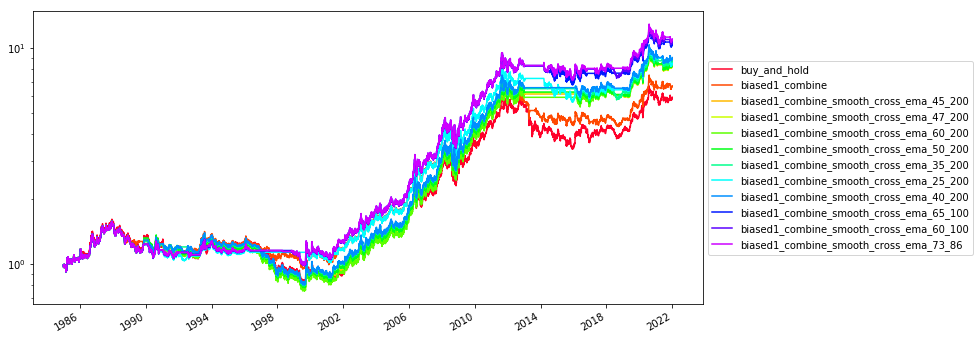

==================================== buy_and_hold


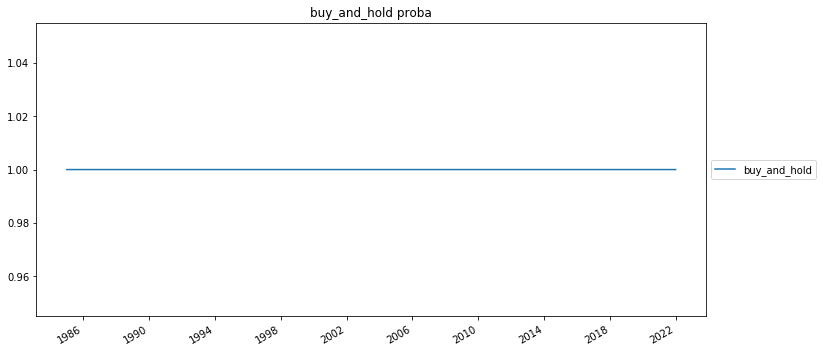

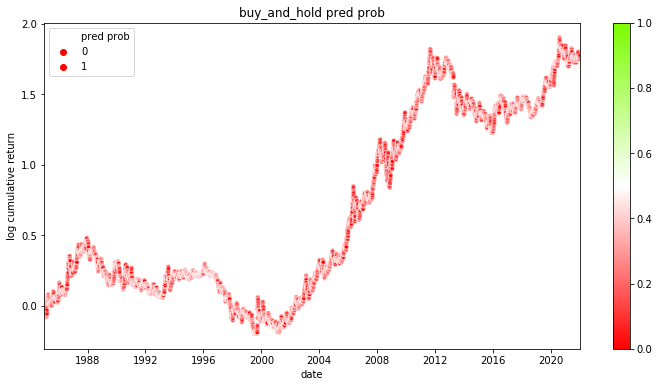

==================================== biased1_combine


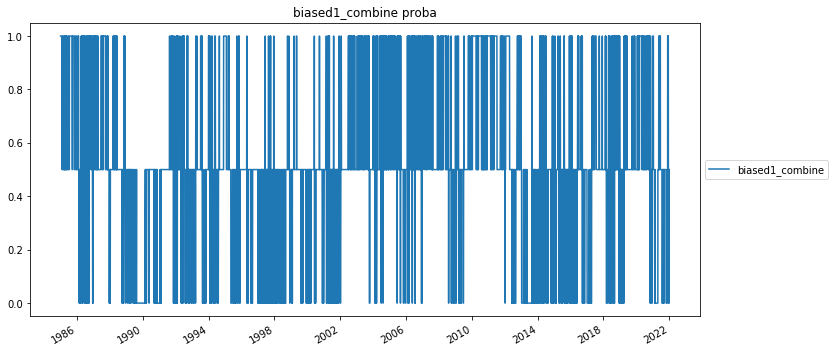

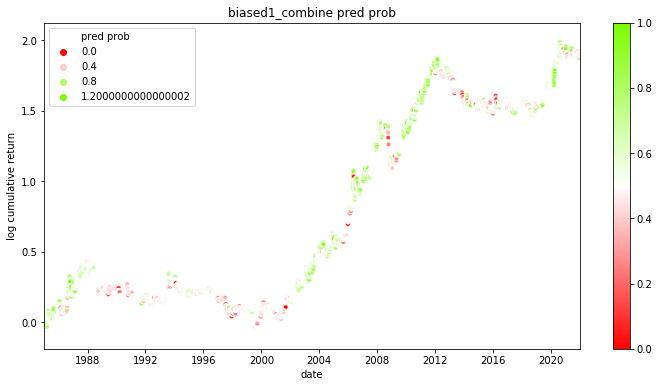

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

highlight_ratio  flip_ratio  \
biased1_combine                                 0.738088    0.134103   
biased1_combine_smooth_cross_ema_45_200         0.881326    0.071048   
biased1_combine_smooth_cross_ema_47_200         0.881326    0.071048   
biased1_combine_smooth_cross_ema_60_200         0.882214    0.069864   
biased1_combine_smooth_cross_ema_50_200         0.882214    0.070456   
biased1_combine_smooth_cross_ema_35_200         0.835454    0.068680   
biased1_combine_smooth_cross_ema_25_200         0.583901    0.059207   
biased1_combine_smooth_cross_ema_40_200         0.880438    0.072232   
biased1_combine_smooth_cross_ema_65_100         0.610240    0.059799   
biased1_combine_smooth_cross_ema_60_100         0.609056    0.059207   
biased1_combine_smooth_cross_ema_73_86          0.609056    0.059207   

                                             accu      prec       mse  
biased1_combine                          0.478544  0.477145  1.254037  
biased1_combine_smooth_cross_ema_45_200  0.460787  0.470786  1.266806  
biased1_combine_smooth_cross_ema_47_200  0.460787  0.470786  1.266806  
biased1_combine_smooth_cross_ema_60_200  0.458124  0.469306  1.269123  
biased1_combine_smooth_cross_ema_50_200  0.460491  0.470647  1.266284  
biased1_combine_smooth_cross_ema_35_200  0.466410  0.472547  1.264160  
biased1_combine_smooth_cross_ema_25_200  0.484759  0.476432  1.253349  
biased1_combine_smooth_cross_ema_40_200  0.461675  0.471261  1.263298  
biased1_combine_smooth_cross_ema_65_100  0.489790  0.481571  1.249866  
biased1_combine_smooth_cross_ema_60_100  0.488606  0.480564  1.250290  
biased1_combine_smooth_cross_ema_73_86   0.489198  0.481050  1.249792

annual_return  sharpe_ratio  \
buy_and_hold                                 -0.042235     -0.283945   
biased1_combine                              -0.026876     -0.204650   
biased1_combine_smooth_cross_ema_45_200      -0.040119     -0.297041   
biased1_combine_smooth_cross_ema_47_200      -0.040119     -0.297041   
biased1_combine_smooth_cross_ema_60_200      -0.042334     -0.316484   
biased1_combine_smooth_cross_ema_50_200      -0.039637     -0.292252   
biased1_combine_smooth_cross_ema_35_200      -0.037467     -0.277312   
biased1_combine_smooth_cross_ema_25_200      -0.025252     -0.218956   
biased1_combine_smooth_cross_ema_40_200      -0.036769     -0.267236   
biased1_combine_smooth_cross_ema_65_100      -0.022501     -0.171290   
biased1_combine_smooth_cross_ema_60_100      -0.022899     -0.175596   
biased1_combine_smooth_cross_ema_73_86       -0.022418     -0.170763   

                                         max_drawdown  avg_drawdown  \
buy_and_hold                                -0.481481     -0.272448   
biased1_combine                             -0.381498     -0.218286   
biased1_combine_smooth_cross_ema_45_200     -0.496240     -0.270935   
biased1_combine_smooth_cross_ema_47_200     -0.496240     -0.270935   
biased1_combine_smooth_cross_ema_60_200     -0.511604     -0.281180   
biased1_combine_smooth_cross_ema_50_200     -0.492841     -0.265172   
biased1_combine_smooth_cross_ema_35_200     -0.484067     -0.257430   
biased1_combine_smooth_cross_ema_25_200     -0.325097     -0.250197   
biased1_combine_smooth_cross_ema_40_200     -0.479023     -0.252404   
biased1_combine_smooth_cross_ema_65_100     -0.357110     -0.238708   
biased1_combine_smooth_cross_ema_60_100     -0.360608     -0.241929   
biased1_combine_smooth_cross_ema_73_86      -0.356378     -0.238416   

                                         return/avgdd  
buy_and_hold                                -0.155021  
biased1_combine                             -0.123125  
biased1_combine_smooth_cross_ema_45_200     -0.148076  
biased1_combine_smooth_cross_ema_47_200     -0.148076  
biased1_combine_smooth_cross_ema_60_200     -0.150557  
biased1_combine_smooth_cross_ema_50_200     -0.149478  
biased1_combine_smooth_cross_ema_35_200     -0.145544  
biased1_combine_smooth_cross_ema_25_200     -0.100929  
biased1_combine_smooth_cross_ema_40_200     -0.145675  
biased1_combine_smooth_cross_ema_65_100     -0.094262  
biased1_combine_smooth_cross_ema_60_100     -0.094651  
biased1_combine_smooth_cross_ema_73_86      -0.094030

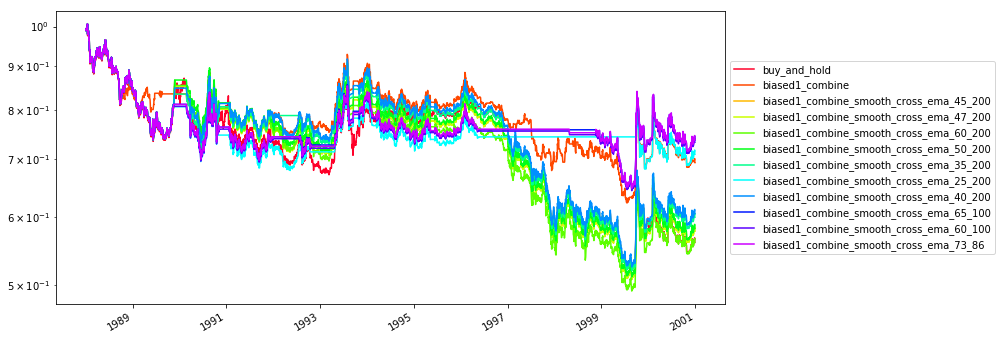

==================================== buy_and_hold


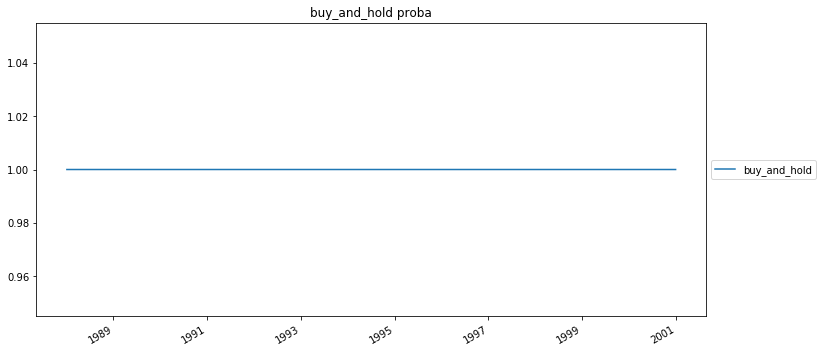

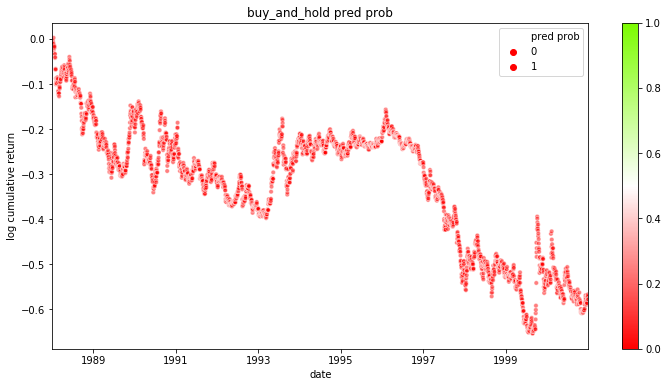

==================================== biased1_combine


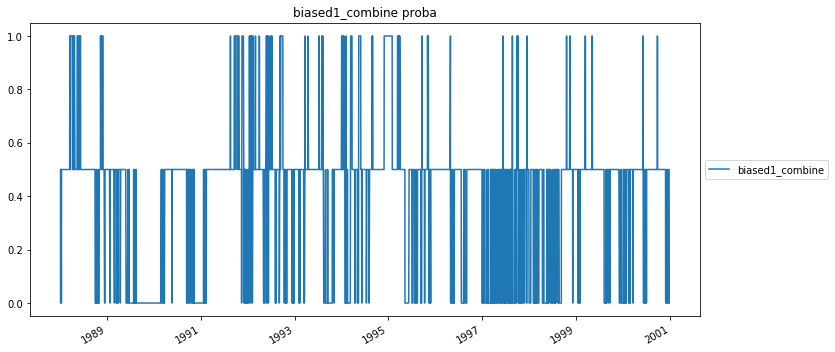

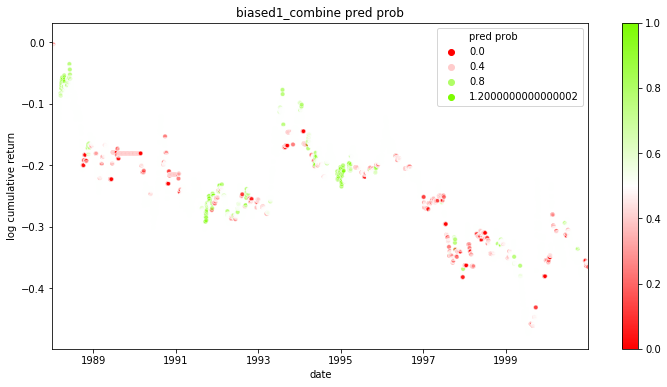

'2001-01-02 00:00:00 to 2005-12-30 00:00:00'

highlight_ratio  flip_ratio  \
biased1_combine                                 0.907763    0.086154   
biased1_combine_smooth_cross_ema_45_200         0.913144    0.075385   
biased1_combine_smooth_cross_ema_47_200         0.913912    0.073846   
biased1_combine_smooth_cross_ema_60_200         0.925442    0.067692   
biased1_combine_smooth_cross_ema_50_200         0.913912    0.073846   
biased1_combine_smooth_cross_ema_35_200         0.911606    0.075385   
biased1_combine_smooth_cross_ema_25_200         0.909301    0.073846   
biased1_combine_smooth_cross_ema_40_200         0.911606    0.075385   
biased1_combine_smooth_cross_ema_65_100         0.919293    0.072308   
biased1_combine_smooth_cross_ema_60_100         0.919293    0.072308   
biased1_combine_smooth_cross_ema_73_86          0.919293    0.072308   

                                             accu      prec       mse  
biased1_combine                          0.520369  0.535140  1.191893  
biased1_combine_smooth_cross_ema_45_200  0.519600  0.534512  1.196964  
biased1_combine_smooth_cross_ema_47_200  0.520369  0.534903  1.194528  
biased1_combine_smooth_cross_ema_60_200  0.521138  0.534884  1.197510  
biased1_combine_smooth_cross_ema_50_200  0.520369  0.534903  1.194528  
biased1_combine_smooth_cross_ema_35_200  0.521138  0.535413  1.193454  
biased1_combine_smooth_cross_ema_25_200  0.518832  0.534235  1.196496  
biased1_combine_smooth_cross_ema_40_200  0.521138  0.535413  1.193454  
biased1_combine_smooth_cross_ema_65_100  0.525749  0.537625  1.186292  
biased1_combine_smooth_cross_ema_60_100  0.525749  0.537625  1.186292  
biased1_combine_smooth_cross_ema_73_86   0.525749  0.537625  1.186292

annual_return  sharpe_ratio  \
buy_and_hold                                  0.132401      0.936292   
biased1_combine                               0.135642      0.987850   
biased1_combine_smooth_cross_ema_45_200       0.128933      0.939360   
biased1_combine_smooth_cross_ema_47_200       0.132056      0.958399   
biased1_combine_smooth_cross_ema_60_200       0.128027      0.926429   
biased1_combine_smooth_cross_ema_50_200       0.132056      0.958399   
biased1_combine_smooth_cross_ema_35_200       0.133497      0.969535   
biased1_combine_smooth_cross_ema_25_200       0.129579      0.945055   
biased1_combine_smooth_cross_ema_40_200       0.133497      0.969535   
biased1_combine_smooth_cross_ema_65_100       0.142752      1.025964   
biased1_combine_smooth_cross_ema_60_100       0.142752      1.025964   
biased1_combine_smooth_cross_ema_73_86        0.142752      1.025964   

                                         max_drawdown  avg_drawdown  \
buy_and_hold                                 -0.15445     -0.042569   
biased1_combine                              -0.15445     -0.039082   
biased1_combine_smooth_cross_ema_45_200      -0.15445     -0.040000   
biased1_combine_smooth_cross_ema_47_200      -0.15445     -0.039579   
biased1_combine_smooth_cross_ema_60_200      -0.15445     -0.041132   
biased1_combine_smooth_cross_ema_50_200      -0.15445     -0.039579   
biased1_combine_smooth_cross_ema_35_200      -0.15445     -0.039705   
biased1_combine_smooth_cross_ema_25_200      -0.15445     -0.040204   
biased1_combine_smooth_cross_ema_40_200      -0.15445     -0.039705   
biased1_combine_smooth_cross_ema_65_100      -0.15445     -0.038865   
biased1_combine_smooth_cross_ema_60_100      -0.15445     -0.038865   
biased1_combine_smooth_cross_ema_73_86       -0.15445     -0.038865   

                                         return/avgdd  
buy_and_hold                                 3.110238  
biased1_combine                              3.470681  
biased1_combine_smooth_cross_ema_45_200      3.223280  
biased1_combine_smooth_cross_ema_47_200      3.336558  
biased1_combine_smooth_cross_ema_60_200      3.112592  
biased1_combine_smooth_cross_ema_50_200      3.336558  
biased1_combine_smooth_cross_ema_35_200      3.362264  
biased1_combine_smooth_cross_ema_25_200      3.223014  
biased1_combine_smooth_cross_ema_40_200      3.362264  
biased1_combine_smooth_cross_ema_65_100      3.673022  
biased1_combine_smooth_cross_ema_60_100      3.673022  
biased1_combine_smooth_cross_ema_73_86       3.673022

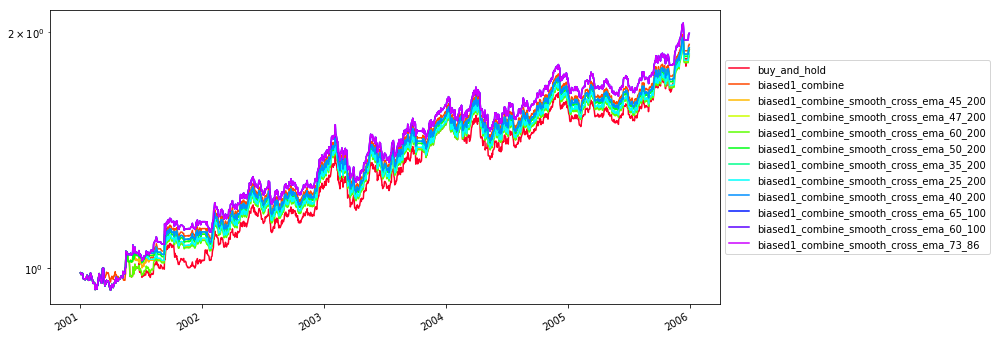

==================================== buy_and_hold


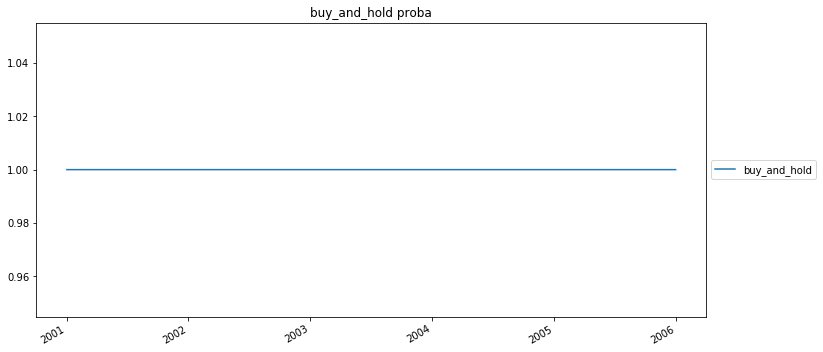

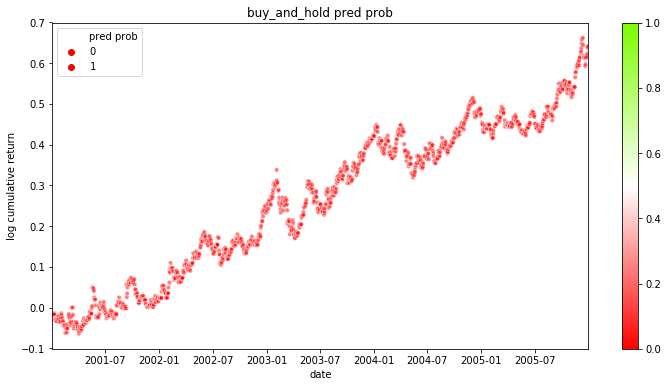

==================================== biased1_combine


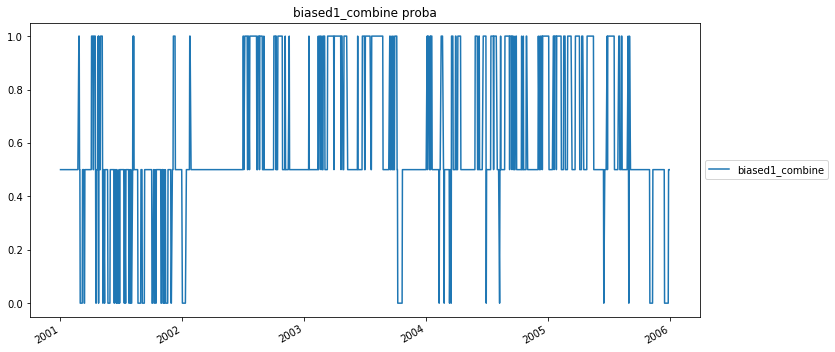

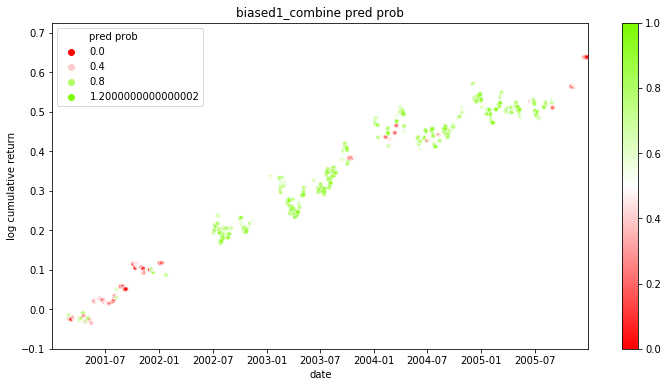

'2006-01-03 00:00:00 to 2008-12-31 00:00:00'

highlight_ratio  flip_ratio  \
biased1_combine                                 0.924456    0.048718   
biased1_combine_smooth_cross_ema_45_200         0.960307    0.033333   
biased1_combine_smooth_cross_ema_47_200         0.960307    0.033333   
biased1_combine_smooth_cross_ema_60_200         0.960307    0.033333   
biased1_combine_smooth_cross_ema_50_200         0.960307    0.033333   
biased1_combine_smooth_cross_ema_35_200         0.960307    0.033333   
biased1_combine_smooth_cross_ema_25_200         0.960307    0.033333   
biased1_combine_smooth_cross_ema_40_200         0.960307    0.033333   
biased1_combine_smooth_cross_ema_65_100         0.960307    0.033333   
biased1_combine_smooth_cross_ema_60_100         0.960307    0.033333   
biased1_combine_smooth_cross_ema_73_86          0.960307    0.033333   

                                             accu      prec       mse  
biased1_combine                          0.524968  0.530471  1.214186  
biased1_combine_smooth_cross_ema_45_200  0.535211  0.534667  1.181436  
biased1_combine_smooth_cross_ema_47_200  0.535211  0.534667  1.181436  
biased1_combine_smooth_cross_ema_60_200  0.535211  0.534667  1.181436  
biased1_combine_smooth_cross_ema_50_200  0.535211  0.534667  1.181436  
biased1_combine_smooth_cross_ema_35_200  0.535211  0.534667  1.181436  
biased1_combine_smooth_cross_ema_25_200  0.535211  0.534667  1.181436  
biased1_combine_smooth_cross_ema_40_200  0.535211  0.534667  1.181436  
biased1_combine_smooth_cross_ema_65_100  0.535211  0.534667  1.181436  
biased1_combine_smooth_cross_ema_60_100  0.535211  0.534667  1.181436  
biased1_combine_smooth_cross_ema_73_86   0.535211  0.534667  1.181436

annual_return  sharpe_ratio  \
buy_and_hold                                  0.186867      0.824008   
biased1_combine                               0.157627      0.753125   
biased1_combine_smooth_cross_ema_45_200       0.230422      0.985124   
biased1_combine_smooth_cross_ema_47_200       0.230422      0.985124   
biased1_combine_smooth_cross_ema_60_200       0.230422      0.985124   
biased1_combine_smooth_cross_ema_50_200       0.230422      0.985124   
biased1_combine_smooth_cross_ema_35_200       0.230422      0.985124   
biased1_combine_smooth_cross_ema_25_200       0.230422      0.985124   
biased1_combine_smooth_cross_ema_40_200       0.230422      0.985124   
biased1_combine_smooth_cross_ema_65_100       0.230422      0.985124   
biased1_combine_smooth_cross_ema_60_100       0.230422      0.985124   
biased1_combine_smooth_cross_ema_73_86        0.230422      0.985124   

                                         max_drawdown  avg_drawdown  \
buy_and_hold                                -0.290117     -0.090528   
biased1_combine                             -0.320385     -0.077101   
biased1_combine_smooth_cross_ema_45_200     -0.277500     -0.070737   
biased1_combine_smooth_cross_ema_47_200     -0.277500     -0.070737   
biased1_combine_smooth_cross_ema_60_200     -0.277500     -0.070737   
biased1_combine_smooth_cross_ema_50_200     -0.277500     -0.070737   
biased1_combine_smooth_cross_ema_35_200     -0.277500     -0.070737   
biased1_combine_smooth_cross_ema_25_200     -0.277500     -0.070737   
biased1_combine_smooth_cross_ema_40_200     -0.277500     -0.070737   
biased1_combine_smooth_cross_ema_65_100     -0.277500     -0.070737   
biased1_combine_smooth_cross_ema_60_100     -0.277500     -0.070737   
biased1_combine_smooth_cross_ema_73_86      -0.277500     -0.070737   

                                         return/avgdd  
buy_and_hold                                 2.064197  
biased1_combine                              2.044417  
biased1_combine_smooth_cross_ema_45_200      3.257444  
biased1_combine_smooth_cross_ema_47_200      3.257444  
biased1_combine_smooth_cross_ema_60_200      3.257444  
biased1_combine_smooth_cross_ema_50_200      3.257444  
biased1_combine_smooth_cross_ema_35_200      3.257444  
biased1_combine_smooth_cross_ema_25_200      3.257444  
biased1_combine_smooth_cross_ema_40_200      3.257444  
biased1_combine_smooth_cross_ema_65_100      3.257444  
biased1_combine_smooth_cross_ema_60_100      3.257444  
biased1_combine_smooth_cross_ema_73_86       3.257444

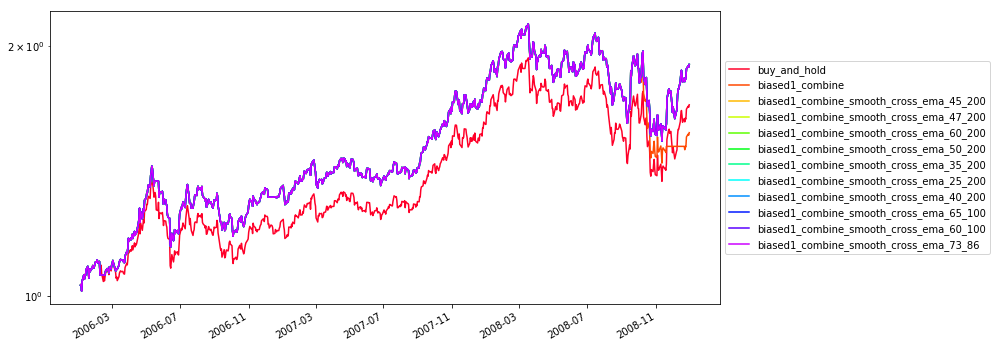

==================================== buy_and_hold


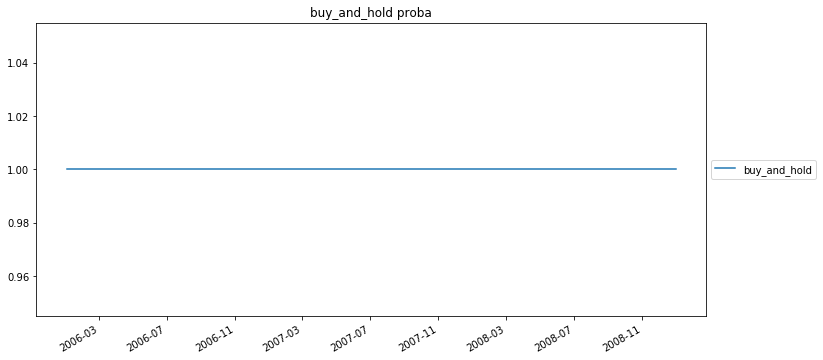

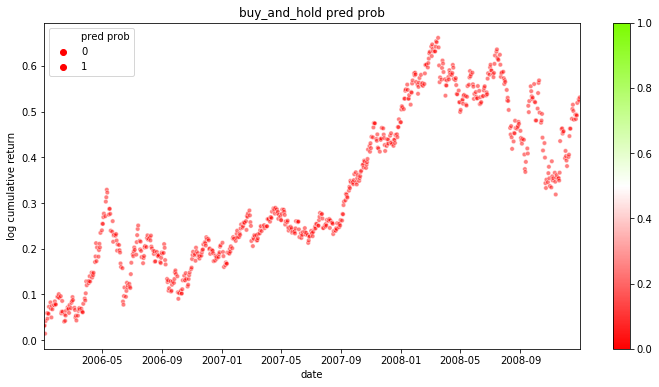

==================================== biased1_combine


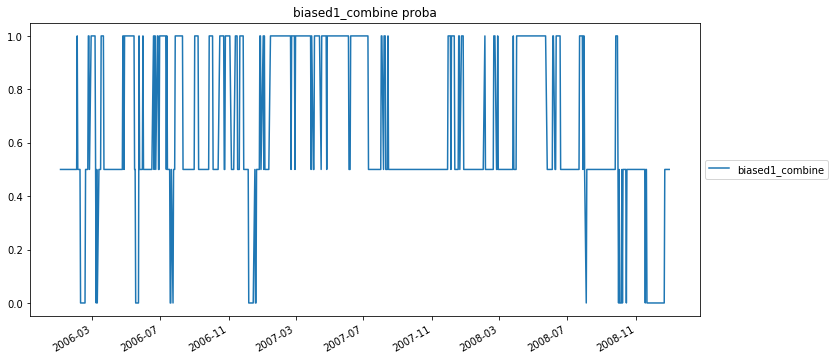

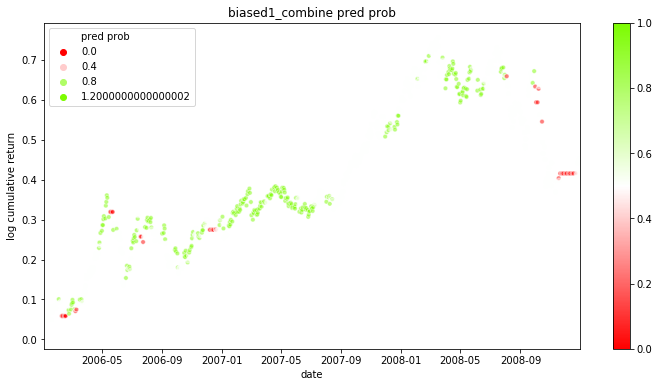

'2009-01-01 00:00:00 to 2011-12-30 00:00:00'

highlight_ratio  flip_ratio  \
biased1_combine                                 0.961637    0.023047   
biased1_combine_smooth_cross_ema_45_200         0.965473    0.020487   
biased1_combine_smooth_cross_ema_47_200         0.965473    0.020487   
biased1_combine_smooth_cross_ema_60_200         0.965473    0.020487   
biased1_combine_smooth_cross_ema_50_200         0.965473    0.020487   
biased1_combine_smooth_cross_ema_35_200         0.965473    0.020487   
biased1_combine_smooth_cross_ema_25_200         0.961637    0.023047   
biased1_combine_smooth_cross_ema_40_200         0.965473    0.020487   
biased1_combine_smooth_cross_ema_65_100         0.965473    0.020487   
biased1_combine_smooth_cross_ema_60_100         0.965473    0.020487   
biased1_combine_smooth_cross_ema_73_86          0.965473    0.020487   

                                             accu      prec       mse  
biased1_combine                          0.558824  0.559840  1.188627  
biased1_combine_smooth_cross_ema_45_200  0.560102  0.560265  1.177944  
biased1_combine_smooth_cross_ema_47_200  0.560102  0.560265  1.177944  
biased1_combine_smooth_cross_ema_60_200  0.560102  0.560265  1.177944  
biased1_combine_smooth_cross_ema_50_200  0.560102  0.560265  1.177944  
biased1_combine_smooth_cross_ema_35_200  0.560102  0.560265  1.177944  
biased1_combine_smooth_cross_ema_25_200  0.558824  0.559840  1.188627  
biased1_combine_smooth_cross_ema_40_200  0.560102  0.560265  1.177944  
biased1_combine_smooth_cross_ema_65_100  0.560102  0.560265  1.177944  
biased1_combine_smooth_cross_ema_60_100  0.560102  0.560265  1.177944  
biased1_combine_smooth_cross_ema_73_86   0.560102  0.560265  1.177944

annual_return  sharpe_ratio  \
buy_and_hold                                  0.203590      1.084884   
biased1_combine                               0.198350      1.086292   
biased1_combine_smooth_cross_ema_45_200       0.217172      1.164213   
biased1_combine_smooth_cross_ema_47_200       0.217172      1.164213   
biased1_combine_smooth_cross_ema_60_200       0.217172      1.164213   
biased1_combine_smooth_cross_ema_50_200       0.217172      1.164213   
biased1_combine_smooth_cross_ema_35_200       0.217172      1.164213   
biased1_combine_smooth_cross_ema_25_200       0.198350      1.086292   
biased1_combine_smooth_cross_ema_40_200       0.217172      1.164213   
biased1_combine_smooth_cross_ema_65_100       0.217172      1.164213   
biased1_combine_smooth_cross_ema_60_100       0.217172      1.164213   
biased1_combine_smooth_cross_ema_73_86        0.217172      1.164213   

                                         max_drawdown  avg_drawdown  \
buy_and_hold                                -0.186157     -0.044423   
biased1_combine                             -0.186157     -0.043125   
biased1_combine_smooth_cross_ema_45_200     -0.186157     -0.042729   
biased1_combine_smooth_cross_ema_47_200     -0.186157     -0.042729   
biased1_combine_smooth_cross_ema_60_200     -0.186157     -0.042729   
biased1_combine_smooth_cross_ema_50_200     -0.186157     -0.042729   
biased1_combine_smooth_cross_ema_35_200     -0.186157     -0.042729   
biased1_combine_smooth_cross_ema_25_200     -0.186157     -0.043125   
biased1_combine_smooth_cross_ema_40_200     -0.186157     -0.042729   
biased1_combine_smooth_cross_ema_65_100     -0.186157     -0.042729   
biased1_combine_smooth_cross_ema_60_100     -0.186157     -0.042729   
biased1_combine_smooth_cross_ema_73_86      -0.186157     -0.042729   

                                         return/avgdd  
buy_and_hold                                 4.583029  
biased1_combine                              4.599452  
biased1_combine_smooth_cross_ema_45_200      5.082482  
biased1_combine_smooth_cross_ema_47_200      5.082482  
biased1_combine_smooth_cross_ema_60_200      5.082482  
biased1_combine_smooth_cross_ema_50_200      5.082482  
biased1_combine_smooth_cross_ema_35_200      5.082482  
biased1_combine_smooth_cross_ema_25_200      4.599452  
biased1_combine_smooth_cross_ema_40_200      5.082482  
biased1_combine_smooth_cross_ema_65_100      5.082482  
biased1_combine_smooth_cross_ema_60_100      5.082482  
biased1_combine_smooth_cross_ema_73_86       5.082482

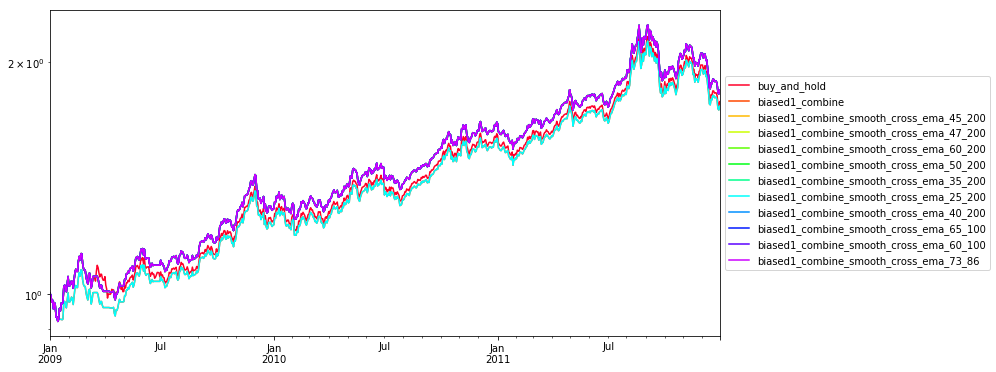

==================================== buy_and_hold


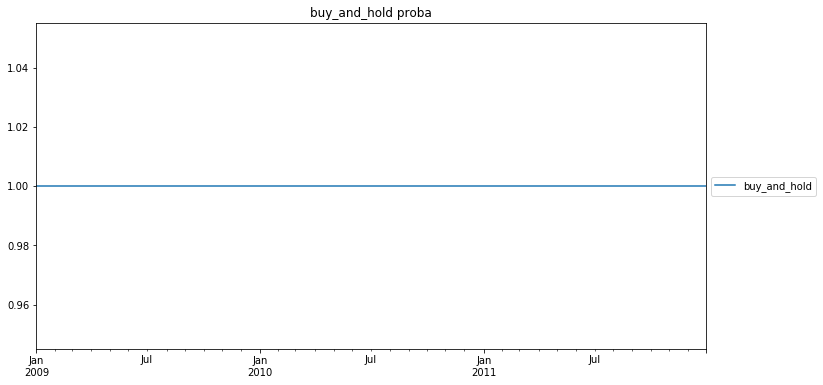

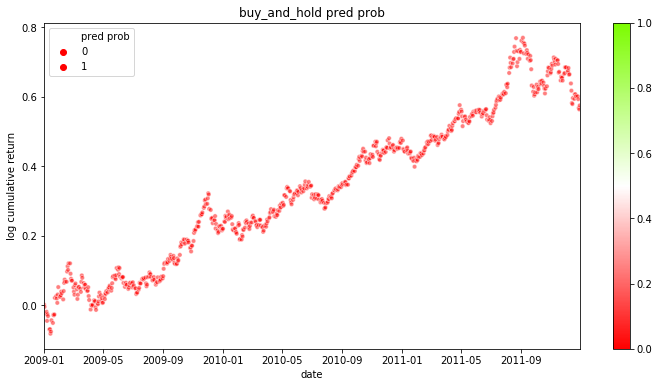

==================================== biased1_combine


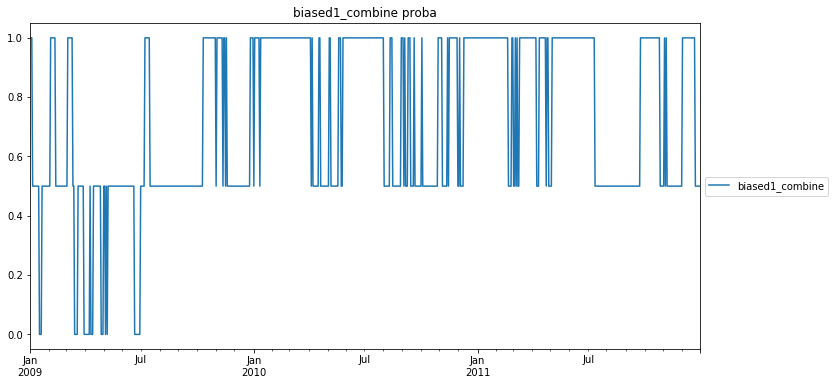

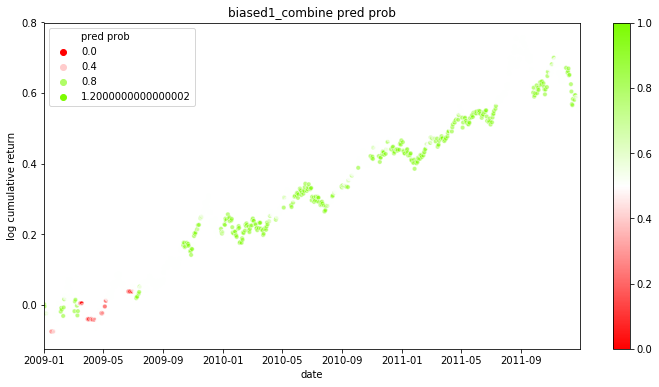

'2012-01-02 00:00:00 to 2015-12-31 00:00:00'

highlight_ratio  flip_ratio  \
biased1_combine                                 0.701536    0.122959   
biased1_combine_smooth_cross_ema_45_200         0.256238    0.002882   
biased1_combine_smooth_cross_ema_47_200         0.256238    0.002882   
biased1_combine_smooth_cross_ema_60_200         0.256238    0.002882   
biased1_combine_smooth_cross_ema_50_200         0.256238    0.002882   
biased1_combine_smooth_cross_ema_35_200         0.255278    0.004803   
biased1_combine_smooth_cross_ema_25_200         0.705374    0.011527   
biased1_combine_smooth_cross_ema_40_200         0.256238    0.002882   
biased1_combine_smooth_cross_ema_65_100         0.645873    0.026897   
biased1_combine_smooth_cross_ema_60_100         0.673704    0.026897   
biased1_combine_smooth_cross_ema_73_86          0.672745    0.026897   

                                             accu      prec       mse  
biased1_combine                          0.483685  0.477428  1.259100  
biased1_combine_smooth_cross_ema_45_200  0.527831  0.524345  1.205200  
biased1_combine_smooth_cross_ema_47_200  0.527831  0.524345  1.205200  
biased1_combine_smooth_cross_ema_60_200  0.527831  0.524345  1.205200  
biased1_combine_smooth_cross_ema_50_200  0.527831  0.524345  1.205200  
biased1_combine_smooth_cross_ema_35_200  0.526871  0.522556  1.205339  
biased1_combine_smooth_cross_ema_25_200  0.477927  0.473469  1.246617  
biased1_combine_smooth_cross_ema_40_200  0.527831  0.524345  1.205200  
biased1_combine_smooth_cross_ema_65_100  0.491363  0.481426  1.239739  
biased1_combine_smooth_cross_ema_60_100  0.488484  0.480057  1.230106  
biased1_combine_smooth_cross_ema_73_86   0.489443  0.480742  1.229952

annual_return  sharpe_ratio  \
buy_and_hold                                 -0.089555     -0.494734   
biased1_combine                              -0.059081     -0.390747   
biased1_combine_smooth_cross_ema_45_200       0.014967      0.236881   
biased1_combine_smooth_cross_ema_47_200       0.014967      0.236881   
biased1_combine_smooth_cross_ema_60_200       0.014967      0.236881   
biased1_combine_smooth_cross_ema_50_200       0.014967      0.236881   
biased1_combine_smooth_cross_ema_35_200       0.014785      0.234481   
biased1_combine_smooth_cross_ema_25_200      -0.042004     -0.302057   
biased1_combine_smooth_cross_ema_40_200       0.014967      0.236881   
biased1_combine_smooth_cross_ema_65_100      -0.033096     -0.233506   
biased1_combine_smooth_cross_ema_60_100      -0.021180     -0.124034   
biased1_combine_smooth_cross_ema_73_86       -0.020986     -0.122342   

                                         max_drawdown  avg_drawdown  \
buy_and_hold                                -0.412616     -0.229167   
biased1_combine                             -0.323740     -0.205460   
biased1_combine_smooth_cross_ema_45_200     -0.137638     -0.070366   
biased1_combine_smooth_cross_ema_47_200     -0.137638     -0.070366   
biased1_combine_smooth_cross_ema_60_200     -0.137638     -0.070366   
biased1_combine_smooth_cross_ema_50_200     -0.137638     -0.070366   
biased1_combine_smooth_cross_ema_35_200     -0.137638     -0.070382   
biased1_combine_smooth_cross_ema_25_200     -0.275488     -0.117224   
biased1_combine_smooth_cross_ema_40_200     -0.137638     -0.070366   
biased1_combine_smooth_cross_ema_65_100     -0.246706     -0.108846   
biased1_combine_smooth_cross_ema_60_100     -0.207570     -0.091822   
biased1_combine_smooth_cross_ema_73_86      -0.206919     -0.091494   

                                         return/avgdd  
buy_and_hold                                -0.390783  
biased1_combine                             -0.287553  
biased1_combine_smooth_cross_ema_45_200      0.212698  
biased1_combine_smooth_cross_ema_47_200      0.212698  
biased1_combine_smooth_cross_ema_60_200      0.212698  
biased1_combine_smooth_cross_ema_50_200      0.212698  
biased1_combine_smooth_cross_ema_35_200      0.210073  
biased1_combine_smooth_cross_ema_25_200     -0.358326  
biased1_combine_smooth_cross_ema_40_200      0.212698  
biased1_combine_smooth_cross_ema_65_100     -0.304064  
biased1_combine_smooth_cross_ema_60_100     -0.230665  
biased1_combine_smooth_cross_ema_73_86      -0.229366

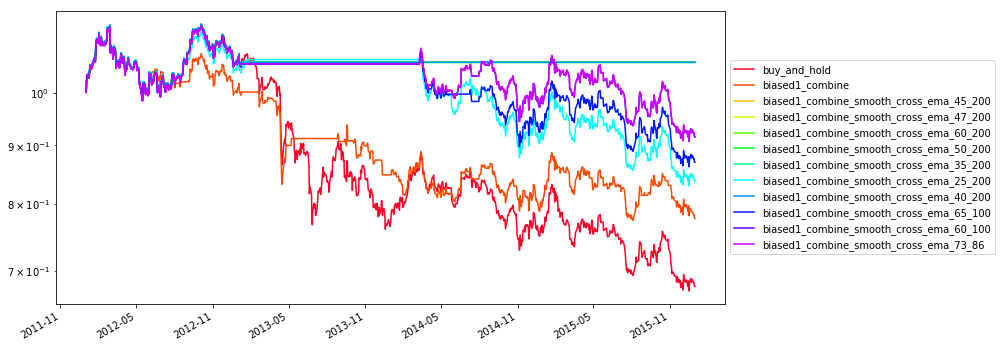

==================================== buy_and_hold


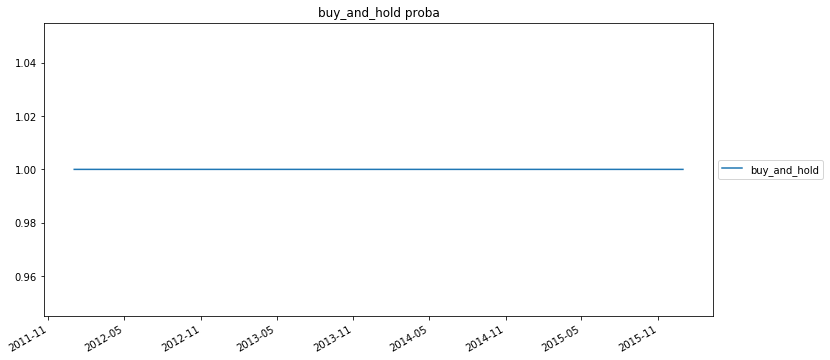

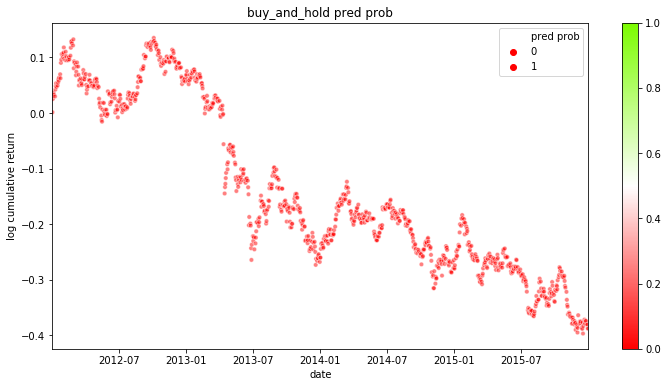

==================================== biased1_combine


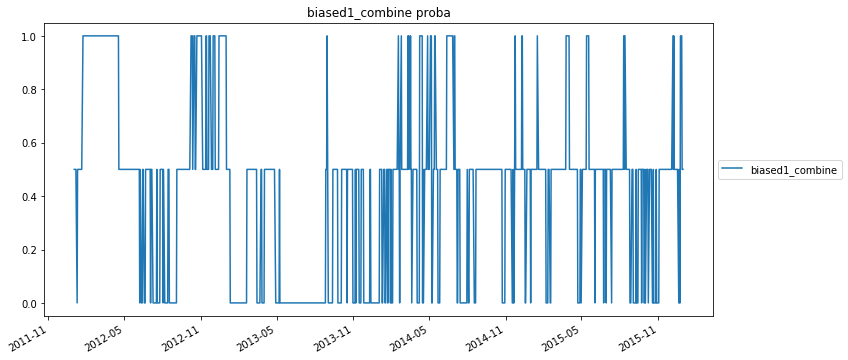

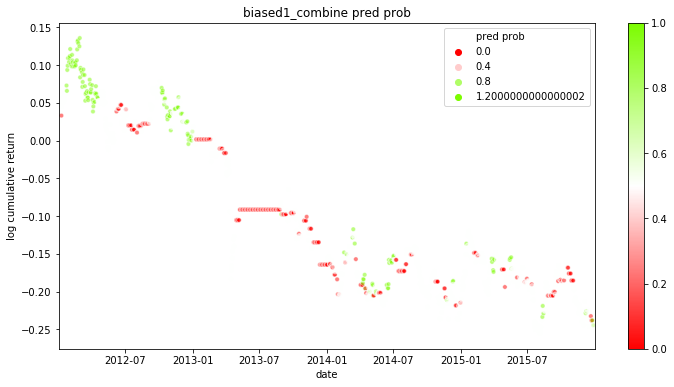

'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  flip_ratio  \
biased1_combine                                 0.820857    0.090269   
biased1_combine_smooth_cross_ema_45_200         0.762636    0.068502   
biased1_combine_smooth_cross_ema_47_200         0.761356    0.067222   
biased1_combine_smooth_cross_ema_60_200         0.760717    0.062100   
biased1_combine_smooth_cross_ema_50_200         0.762636    0.067222   
biased1_combine_smooth_cross_ema_35_200         0.852847    0.069782   
biased1_combine_smooth_cross_ema_25_200         0.723608    0.066581   
biased1_combine_smooth_cross_ema_40_200         0.761996    0.069782   
biased1_combine_smooth_cross_ema_65_100         0.714651    0.062740   
biased1_combine_smooth_cross_ema_60_100         0.809981    0.061460   
biased1_combine_smooth_cross_ema_73_86          0.714651    0.062740   

                                             accu      prec       mse  
biased1_combine                          0.522073  0.535464  1.225654  
biased1_combine_smooth_cross_ema_45_200  0.522713  0.538591  1.243663  
biased1_combine_smooth_cross_ema_47_200  0.522713  0.538655  1.245499  
biased1_combine_smooth_cross_ema_60_200  0.527191  0.541632  1.237335  
biased1_combine_smooth_cross_ema_50_200  0.523992  0.539430  1.245147  
biased1_combine_smooth_cross_ema_35_200  0.522073  0.534134  1.244372  
biased1_combine_smooth_cross_ema_25_200  0.522073  0.540230  1.228719  
biased1_combine_smooth_cross_ema_40_200  0.525912  0.540722  1.241634  
biased1_combine_smooth_cross_ema_65_100  0.518234  0.538048  1.225295  
biased1_combine_smooth_cross_ema_60_100  0.516315  0.532385  1.227593  
biased1_combine_smooth_cross_ema_73_86   0.518234  0.538048  1.225295

annual_return  sharpe_ratio  \
buy_and_hold                                  0.091659      0.718013   
biased1_combine                               0.070731      0.615802   
biased1_combine_smooth_cross_ema_45_200       0.050848      0.476434   
biased1_combine_smooth_cross_ema_47_200       0.048820      0.461006   
biased1_combine_smooth_cross_ema_60_200       0.058020      0.534542   
biased1_combine_smooth_cross_ema_50_200       0.049215      0.464177   
biased1_combine_smooth_cross_ema_35_200       0.049573      0.455632   
biased1_combine_smooth_cross_ema_25_200       0.067869      0.614109   
biased1_combine_smooth_cross_ema_40_200       0.053128      0.494570   
biased1_combine_smooth_cross_ema_65_100       0.071664      0.639775   
biased1_combine_smooth_cross_ema_60_100       0.068567      0.601005   
biased1_combine_smooth_cross_ema_73_86        0.071664      0.639775   

                                         max_drawdown  avg_drawdown  \
buy_and_hold                                -0.185126     -0.066784   
biased1_combine                             -0.147879     -0.074481   
biased1_combine_smooth_cross_ema_45_200     -0.182420     -0.061352   
biased1_combine_smooth_cross_ema_47_200     -0.182420     -0.060855   
biased1_combine_smooth_cross_ema_60_200     -0.182754     -0.059169   
biased1_combine_smooth_cross_ema_50_200     -0.182420     -0.060710   
biased1_combine_smooth_cross_ema_35_200     -0.177727     -0.064507   
biased1_combine_smooth_cross_ema_25_200     -0.197511     -0.062063   
biased1_combine_smooth_cross_ema_40_200     -0.180847     -0.060436   
biased1_combine_smooth_cross_ema_65_100     -0.190414     -0.059882   
biased1_combine_smooth_cross_ema_60_100     -0.190414     -0.066113   
biased1_combine_smooth_cross_ema_73_86      -0.190414     -0.059882   

                                         return/avgdd  
buy_and_hold                                 1.372467  
biased1_combine                              0.949651  
biased1_combine_smooth_cross_ema_45_200      0.828786  
biased1_combine_smooth_cross_ema_47_200      0.802232  
biased1_combine_smooth_cross_ema_60_200      0.980575  
biased1_combine_smooth_cross_ema_50_200      0.810664  
biased1_combine_smooth_cross_ema_35_200      0.768493  
biased1_combine_smooth_cross_ema_25_200      1.093554  
biased1_combine_smooth_cross_ema_40_200      0.879086  
biased1_combine_smooth_cross_ema_65_100      1.196761  
biased1_combine_smooth_cross_ema_60_100      1.037112  
biased1_combine_smooth_cross_ema_73_86       1.196761

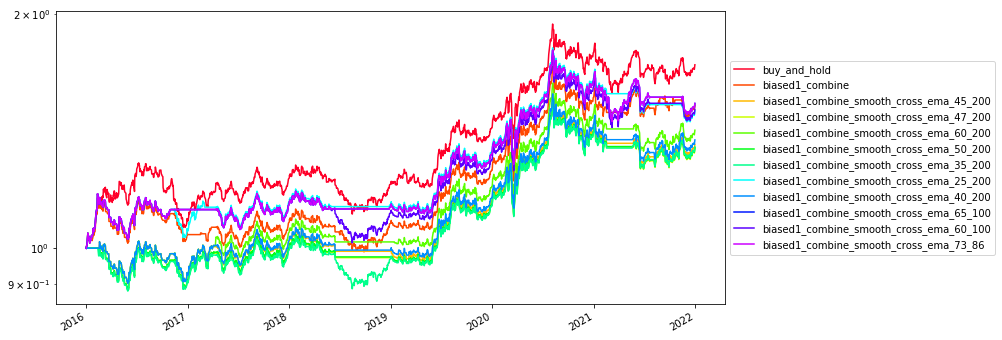

==================================== buy_and_hold


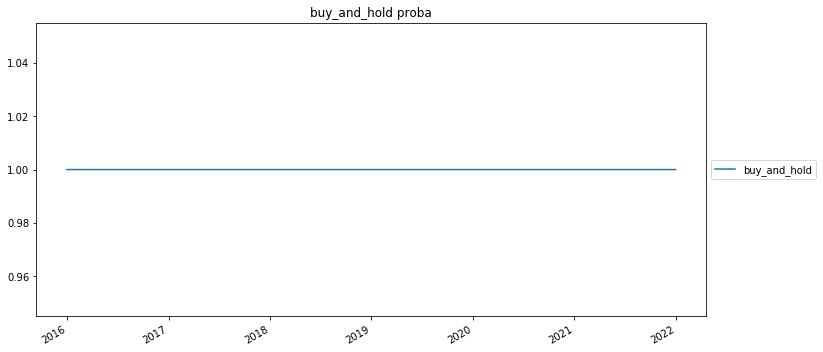

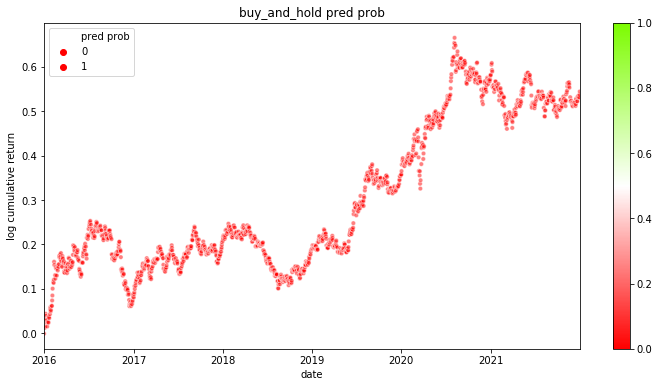

==================================== biased1_combine


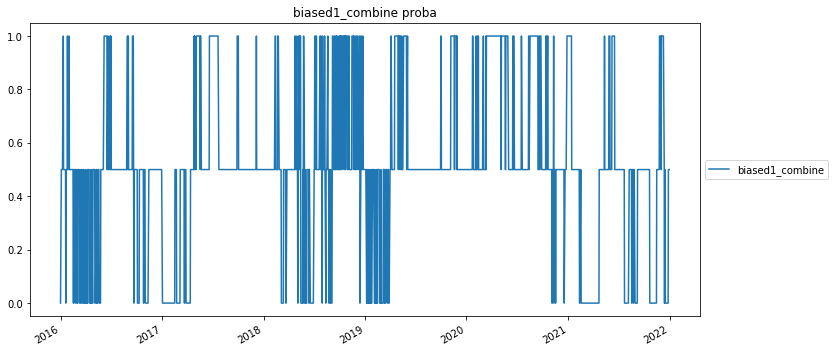

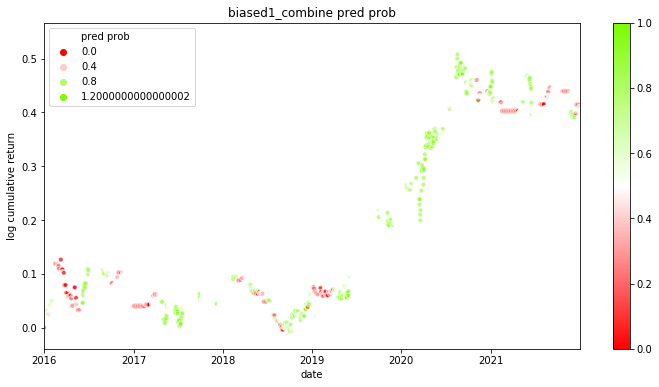

['buy_and_hold',
 'biased1_combine',
 'biased1_combine_smooth_cross_ema_45_200',
 'biased1_combine_smooth_cross_ema_47_200',
 'biased1_combine_smooth_cross_ema_60_200',
 'biased1_combine_smooth_cross_ema_50_200',
 'biased1_combine_smooth_cross_ema_35_200',
 'biased1_combine_smooth_cross_ema_25_200',
 'biased1_combine_smooth_cross_ema_40_200',
 'biased1_combine_smooth_cross_ema_65_100',
 'biased1_combine_smooth_cross_ema_60_100',
 'biased1_combine_smooth_cross_ema_73_86']

In [65]:
# cases = list(ret_pred_all.columns)
# cases.remove('true_up')

# cases = ['vote_lookbackA_rollA_top20', 'biased1_combine', 'buy_and_hold']

strategy_list_sel = print_all_result(ret_pred_case2, proba_all, base_case=cases)

print_all_result(ret_pred_case2['1988':'2000'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case2['2001':'2005'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case2['2006':'2008'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case2['2009':'2011'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case2['2012':'2015'], proba_all, strategy_list_sel=strategy_list_sel)
print_all_result(ret_pred_case2['2016':'2021'], proba_all, strategy_list_sel=strategy_list_sel)

In [ ]:
for year in [2006, 2007, 2008]:
    for m in range(1, 13):
        if m < 10:
            m = "{}-0{}".format(year, m)
        else:
            m = "{}-{}".format(year, m)
        pred_all[m].plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
        print_all_result(ret_pred_all[m], proba_all)